# Evaluation Analysis

## loading data and modules

In [1]:
# module, data, feature list loading
import pandas as pd
from warnings import simplefilter
from tqdm import tqdm
import numpy as np
simplefilter(action="ignore", category=pd.errors.DtypeWarning)
pd.set_option('display.max_columns', None)

import pickle
import matplotlib.pyplot as plt
from IPython.display import clear_output

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import MinMaxScaler as mm_scaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

# feature and data loading

demo_list = ['height', 'weight', 'bmi', 'gender']# => race using postponed
vital_list = ['heart_rate', 'resp_rate', 'temperature', 'sbp', 'dbp', 'map', 'paco2', 'pao2', 'fio2']
lab_list = ['gcs', 'bilirubin', 'platelets', 'creatinine', 'lactate', 'bun', 'arterial_ph', 'wbc', 'hemoglobin', 'hematocrit','potassium', 'sodium', 'urine_output']
vaso_list = ['epinephrine', 'dopamine', 'dobutamine', 'norepinephrine', 'phenylephrine', 'vasopressin']
fl_vent_list = ['fluid', 'ventilator']

sofa_list = ['CNS_SOFA', 'CARDIO_SOFA', 'RESP_SOFA', 'COAG_SOFA', 'LIVER_SOFA', 'RENAL_SOFA', 'SOFA']
label_list = ['SEPSIS', 'SHOCK']
core_list = ['sbp', 'dbp', 'map', 'pao2', 'fio2', 'lactate', 'arterial_ph', 'gcs', 'creatinine', 'bilirubin', 'platelets']

tmp = demo_list+vital_list+lab_list+fl_vent_list+vaso_list
tmp = [i+'_value' for i in tmp if i not in ['bmi', 'gender']]
tmp += [i+'_rate' for i in vaso_list]
tmp += ['SEPSIS', 'vaso_presence']+sofa_list
base_features = tmp.copy()

statistic_features = [i+j for i in core_list for j in ['_min', '_median', '_max', '_presence']]
slope_features = [i+'_slp'+str(j) for i in core_list for j in [1,3,5]]

feature_dict = {}
vaso_fetures = {
    0 : ['SOFA'],
    1 : ['CARDIO_SOFA', 'vaso_presence'],
    2 : [i+'_rate' for i in vaso_list]+[i+'_value' for i in vaso_list]
}
for vaso_lv, fe_lv in [(a, b) for a in [0, 1, 2, 3] for b in [0, 1, 2]]:
    tmp_features = base_features.copy()
    if vaso_lv == 0:
        tmp_features = list(set(tmp_features)-set(vaso_fetures[0]+vaso_fetures[1]+vaso_fetures[2]))
    elif vaso_lv == 1:
        tmp_features = list(set(tmp_features)-set(vaso_fetures[1]+vaso_fetures[2]))
    elif vaso_lv == 2:
        tmp_features = list(set(tmp_features)-set(vaso_fetures[2]))
    
    if fe_lv == 2:
        tmp_features = tmp_features + statistic_features + slope_features
    elif fe_lv == 1:
        tmp_features = tmp_features + statistic_features

    feature_dict[f'vaso{vaso_lv}_fe{fe_lv}'] = tmp_features.copy()

curr_targets = [f'label_pw{a}_tw{b}_ftf{c}'for a in np.arange(1,13) for b in [0, 1, 2, 999] for c in [0, 1]]

icustays = pd.read_csv('processed_data/sepsis/icustays_tab_1hr_v1.csv')
icustays = icustays.loc[icustays.cohort_stays_tab_1hr_v1 == 1].reset_index(drop=True)
stayids = icustays.stay_id.tolist()
shock_ids = icustays[icustays.shock_tab_1hr_v1 == 1].stay_id.tolist()
nonshock_ids = [i for i in stayids if i not in shock_ids]

data = pd.read_csv('sepsis_data_T1FLSv3_df.csv')# with cvp
data.gender = np.where(data.gender == 'F', 1, 0)
data.gender = pd.to_numeric(data.gender)
data.bmi = np.nan_to_num(data.bmi, posinf=0)

In [157]:
'''
whole_data = pd.read_csv('sepsis_data_t1v2FE_df_bfst.csv')
data['vaso_presence'] = whole_data['vaso_presence']
data['SOFA'] = whole_data['SOFA']
data.to_csv('sepsis_data_T1FLSv2_df.csv', index=False)
'''

In [2]:
seed = 230726
seed = f'{seed}_wage'
training_settings = [(a, b, c, d) for a in np.arange(1,13) for b in [0, 1, 2, 999] for c in [0, 1] for d in ['cat', 'xgb', 'lgb', 'rf', 'lr', 'dt', 'nb']]
with open(f'sepsis_data_risk_dict_{seed}.pkl', 'rb') as f:
    risk_dict = pickle.load(f)

In [3]:
def timeliness(x, criteria={'from': [-8], 'to':[0]}):
    if (x['target'].sum() == 0):
        repetition = len(criteria['from'])*len(criteria['to'])
        return np.repeat([[np.nan, np.nan, np.nan, 0, 0, x['alarm'].sum(), x['alarm'].sum()]], repetition, axis=0).ravel() # EWP 계산에만 산입
    
    else:
        if (x['alarm'].sum() == 0):
            repetition = len(criteria['from'])*len(criteria['to'])
            t_idx = np.sort(x[x['target']==1].index)

            tmp_t_idx = [t_idx[0]]
            t_onset_idx = [t_idx[0]]
            for i in t_idx[1:]:
                if (i - tmp_t_idx[-1]) > 1:
                    t_onset_idx.append(i)

                tmp_t_idx.append(i)

            return np.repeat([[0, 0, len(t_onset_idx), 0, 0, 0, 0]], repetition, axis=0).ravel() # 이 경우 (ewr, ewp)_stay = 0 
        
        else:
            t_idx = np.sort(x[x['target']==1].index)
            a_idx = np.sort(x[x['alarm']==1].index)

            oe_pairs = []
            tmp_oe = [t_idx[0]]
            for idx in t_idx:
                if (idx - tmp_oe[-1]) > 1:
                    oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
                    tmp_oe = []
                tmp_oe.append(idx)
            oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
            t_onset_idx = np.array(oe_pairs)[:, 0]
            t_end_idx = np.array(oe_pairs)[:, 1]

            results = []            
            for f, t in [(a, b) for a in criteria['from'] for b in criteria['to']]:
                tmp_result = [0 for _ in range(7)]
                tmp_result[2] = len(t_onset_idx)

                # all shock
                tt_num = 0
                ta = []
                for i in t_onset_idx:
                    tmp_ta = a_idx[(a_idx<(i+t))&(a_idx>=(i+f))].tolist()
                    if len(tmp_ta) > 0:
                        tt_num += 1
                        ta += tmp_ta
                ta = list(set(ta))
                tmp_result[0] = tt_num
                tmp_result[3] = len(ta)
                
                fa_idx = set(a_idx)-set(ta)
                fa_idx = set(fa_idx)-set(t_idx)
                tmp_result[5] = len(fa_idx) + len(ta)

                # first shock
                tt_num = 0
                ta = []
                tmp_ta = a_idx[(a_idx<(t_idx[0]+t))&(a_idx>=(t_idx[0]+f))].tolist()
                if len(tmp_ta) > 0:
                    tt_num += 1
                    ta += tmp_ta
                tmp_result[1] = tt_num
                tmp_result[4] = len(ta)
                tmp_result[6] = len(a_idx[a_idx<(t_idx[0]+t)])

                results += tmp_result
                
                return results

def timeliness_eval_ens(model_settings, exp_setting, data, risk_dict, seed, voting, eval_split=['val'], cutoffs=np.round(np.arange(0.01, 1, 0.01), 2), adj_option='mm'):
    target_col = ['SHOCK']
    data.columns = [i if i not in target_col else 'target' for i in data.columns]

    print(f'{voting} ensembling....', sep=' ')
    if voting == 'hard':
        alarms = []
        for mdlst in tqdm(model_settings):
            # risk score loading
            if exp_setting.__contains__('oscal'):
                pw, tw, ftf, mdl, os, cal, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_os{os}_cal{cal}_seed{seed}'
            else:
                pw, tw, ftf, mdl, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
            
            data['risk_score'] = risk_dict[key_name]
            tmp_data = data.loc[data[f'split_{seed}'].isin(eval_split), ['risk_score']].dropna()
            tmp_data['alarm'] = np.where(tmp_data['risk_score'] >= cf, 1, 0)

            alarms.append(tmp_data['alarm'].tolist())
        
        alarms = np.array(alarms).mean(axis=0)
        print('done')

    elif voting == 'soft':
        risks = []
        for mdlst in tqdm(model_settings):
            # risk score loading
            if exp_setting.__contains__('oscal'):
                pw, tw, ftf, mdl, os, cal, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_os{os}_cal{cal}_seed{seed}'
            else:
                pw, tw, ftf, mdl, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
                
            data['risk_score'] = risk_dict[key_name]
            tmp_data = data.loc[data[f'split_{seed}'].isin(eval_split), ['risk_score']].dropna()
            risks.append(tmp_data['risk_score'].tolist())

        risks = np.array(risks)
        risk_maxs = risks.max(axis=1).reshape(-1,1)
        risk_mins = risks.min(axis=1).reshape(-1,1)
        risk_mus = risks.mean(axis=1).reshape(-1,1)
        risk_stds = risks.std(axis=1).reshape(-1,1)

        if adj_option == 'mm':
            adjusted_risks = (risks-risk_mins)/(risk_maxs-risk_mins)
        elif adj_option == 'ss':
            adjusted_risks = (risks-risk_mus)/(risk_stds)
            adjusted_risks = (adjusted_risks-adjusted_risks.min())/(adjusted_risks.max()-adjusted_risks.min())
        else:
            adjusted_risks = risks

        adjusted_risks = adjusted_risks.mean(axis=0)

        print('done')

    else:
        return 'error! error!'

    eval_results = []
    tmp_data = data.loc[data[f'split_{seed}'].isin(eval_split), ['stay_id', 'target', 'risk_score']].dropna()

    print('evaluating....', sep=' ')
    for cf in tqdm(cutoffs):
        if voting == 'hard':
            tmp_data['alarm'] = np.where(alarms > cf, 1, 0)
        elif voting == 'soft':
            tmp_data['risk_score'] = adjusted_risks
            tmp_data['alarm'] = np.where(tmp_data['risk_score'] > cf, 1, 0)

        ver = ['_8_0']

        tlns_result = pd.DataFrame(tmp_data.groupby(['stay_id']).apply(timeliness).to_list(), columns=[b+a 
                                                                                                        for a in ver 
                                                                                                        for b in ['att', 'ftt', 'at', 'ata', 'fta', 'aa', 'faa']]) 
        

        for i in range(len(ver)):
            tmp_tlns_result = tlns_result.iloc[:,i*7:(i+1)*7]
            tmp = tmp_tlns_result.sum().to_numpy()
            tmp_no_na = tmp_tlns_result.dropna()
            
            tmp_eval = [cf, 'ew'+ver[i]]
            tmp_eval += [tmp[0]/tmp[2], # EWR
                            tmp[3]/tmp[5] if tmp[5] !=0 else 0, # EWP
                            tmp[1]/tmp_no_na.shape[0], # EWR_fs
                            tmp[4]/tmp[6] if tmp[6] !=0 else 0] # EWP_fs
                        
            
            tmp = tmp_no_na.eval(f'ewr_stay = att{ver[i]}/at{ver[i]}').mean()
            tmp_eval += [tmp['ewr_stay']]

            tmp = tmp_no_na.eval(f'ewp_stay = ata{ver[i]}/aa{ver[i]}')
            tmp['ewp_stay'] = [i if i >=0 else 0 for i in tmp['ewp_stay']]
            tmp_eval += [tmp['ewp_stay'].mean()]

            tmp = tmp_no_na.eval(f'ewp_f_stay = fta{ver[i]}/faa{ver[i]}')
            tmp['ewp_f_stay'] = [i if i >=0 else 0 for i in tmp['ewp_f_stay']]
            tmp_eval += [tmp['ewp_f_stay'].mean()]
                
            eval_results.append(tmp_eval)

    print('done')
    return eval_results

## re-evaluation

### prediction task performance

In [9]:
def conf_mat(true, pred):
    tp = ((pred == 1) & (true == 1)).sum()
    fp = ((pred == 1) & (true == 0)).sum()
    fn = ((pred == 0) & (true == 1)).sum()
    tn = ((pred == 0) & (true == 0)).sum()

    return tp, fp, fn, tn

def PTP_eval(training_setting, data, risk_dict, seed, cutoffs=np.round(np.arange(0.05, 1, 0.05), 2)):
    # task performance evaluation---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    data = data.copy()

    pw, tw, ftf, mdl = training_setting
    
    # risk score loading
    key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
    data['risk_score'] = risk_dict[key_name]
    
    eval_result = []
    for cf in cutoffs:
        tmp_eval_result = [pw, tw, ftf, mdl, cf]
        for eval_on_shock, first_onset_task in [(a, b) for a in [1, 0] for b in[0, 1]]:
            target_col = [f'label_pw{pw}_tw{999*(1-eval_on_shock)}_ftf{first_onset_task}']
            tmp_data = data.loc[data[f'split_{seed}']=='val', target_col+['risk_score']].dropna()
            tmp_data['alarm'] = np.where(tmp_data['risk_score']>cf, 1, 0)
            pred = tmp_data['alarm'].values.ravel()
            true = tmp_data[target_col].values.ravel()
            
            tp, fp, fn, tn = conf_mat(true, pred)
            tpr = tp/(tp+fn)
            ppv = tp/(tp+fp) if tp+fp != 0 else 0
            f1 = 2*tp/(fp+2*tp+fn)
            tmp_eval_result += [tpr, ppv, f1]
        
        eval_result.append(tmp_eval_result)
        
    return eval_result

In [12]:
eval_results = []

for trst in tqdm(training_settings):
    eval_results += PTP_eval(trst, data, risk_dict, seed)

100%|██████████| 672/672 [2:15:27<00:00, 12.09s/it]  


In [13]:
col_names = ['pw', 'tw', 'ftf', 'model', 'cutoff'] + [f'as{b}_es{c}_{a}' for c in [0, 1] for b in [1, 0] for a in ['tpr', 'ppv', 'f1']]
ptp_eval_df = pd.DataFrame(eval_results, columns=col_names)
ptp_eval_df

,pw,tw,ftf,model,cutoff,as1_es0_tpr,as1_es0_ppv,as1_es0_f1,as0_es0_tpr,as0_es0_ppv,as0_es0_f1,as1_es1_tpr,as1_es1_ppv,as1_es1_f1,as0_es1_tpr,as0_es1_ppv,as0_es1_f1
0,1,0,0,cat,0.05,0.474419,0.157895,0.236934,0.603053,0.185012,0.283154,0.380714,0.756875,0.506603,0.465047,0.780011,0.582690
1,1,0,0,cat,0.10,0.334884,0.279070,0.304440,0.465649,0.283721,0.352601,0.193464,0.818490,0.312956,0.266644,0.821538,0.402614
2,1,0,0,cat,0.15,0.251163,0.312139,0.278351,0.358779,0.307190,0.330986,0.112470,0.802575,0.197292,0.162117,0.803630,0.269806
3,1,0,0,cat,0.20,0.200000,0.361345,0.257485,0.297710,0.351351,0.322314,0.077987,0.817227,0.142387,0.118842,0.816934,0.207498
4,1,0,0,cat,0.25,0.158140,0.361702,0.220065,0.251908,0.358696,0.295964,0.055934,0.804035,0.104592,0.087883,0.802432,0.158416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12763,12,999,1,nb,0.75,0.148197,0.138565,0.143219,0.170379,0.201051,0.184448,0.162494,0.420195,0.234359,0.185331,0.531274,0.274800
12764,12,999,1,nb,0.80,0.131803,0.145022,0.138097,0.154788,0.216511,0.180519,0.149268,0.441135,0.223059,0.172713,0.560580,0.264068
12765,12,999,1,nb,0.85,0.116721,0.155323,0.133283,0.142539,0.246154,0.180536,0.133995,0.464773,0.208018,0.156151,0.596985,0.247552
12766,12,999,1,nb,0.90,0.096393,0.172738,0.123737,0.115813,0.275132,0.163009,0.117462,0.510959,0.191013,0.136961,0.649626,0.226227


In [14]:
ptp_eval_df.to_csv(f'processed_data/sepsis/eval_modeling/eval_ptp_{seed}_cf_ver.csv', index=False)

## misalignment

### analysis proportion

In [5]:
seed = 230726
seed = f'{seed}_wage'
tlns_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_tlns_{seed}.csv')
tpb_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_tpb_{seed}.csv')
cb_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_cb_{seed}_cf.csv')

tlns_eval_df = tlns_eval_df.set_index(['pw','tw','ftf','model'])
cb_eval_df = cb_eval_df.set_index(['pw','tw','ftf','model'])
tmp_tpb_eval_df = tpb_eval_df.query(f'eval_during_prolonging=={1} & first_onset=={0}').set_index(['pw','tw','ftf','model'])

threshold = {
    'TER' : [0.9],
    'TAR' : [0.2]
}
ca_settings = tlns_eval_df.query(f'(TER > {threshold["TER"][0]}) & (TAR > {threshold["TAR"][0]})').index.unique()

In [6]:
percentiles_ter = tlns_eval_df.query(f'TER > {threshold["TER"][0]}').shape[0]/tlns_eval_df.shape[0]
percentiles_tar = tlns_eval_df.query(f'TAR > {threshold["TAR"][0]}').shape[0]/tlns_eval_df.shape[0]
percentiles = len(ca_settings)/(len(tlns_eval_df.index.unique()))

cb_f1 = cb_eval_df["f1"].groupby(['pw','tw','ftf','model']).max().quantile(1-percentiles)
cb_auroc = cb_eval_df["auroc"].groupby(['pw','tw','ftf','model']).max().quantile(1-percentiles)

tpb_f1 = tmp_tpb_eval_df["f1"].groupby(['pw','tw','ftf','model']).max().quantile(1-percentiles)
tpb_auprc = tmp_tpb_eval_df["auprc"].groupby(['pw','tw','ftf','model']).max().quantile(1-percentiles)

print(f'percent:{percentiles}, cb_f1:{cb_f1}, cb_auroc:{cb_auroc}, tpb_f1:{tpb_f1}, tpb_auprc:{tpb_auprc}')

percent:0.049107142857142856, cb_f1:0.7289613777455834, cb_auroc:0.782779771665566, tpb_f1:0.930671249295968, tpb_auprc:0.9411315985335684


In [7]:
crepant_cbm_eval_df = cb_eval_df.loc[ca_settings].query(f'(auroc > {cb_auroc})')
crepant_settings = crepant_cbm_eval_df.index.unique()
discrepant_settings = [i for i in ca_settings if i not in crepant_settings]
discrepant_cbm_eval_df = cb_eval_df.loc[discrepant_settings]

discrepant_tlns_eval_df = tlns_eval_df.loc[discrepant_settings]
discrepant_tlns_eval_df = discrepant_tlns_eval_df.query(f'TER > {threshold["TER"][0]} & (TAR > {threshold["TAR"][0]})')

proportion = len(discrepant_settings)/len(ca_settings)
tlns_perf = discrepant_tlns_eval_df[['TER', 'TAR']].max().tolist()

print(f'proportion: {proportion}, tlns_perf: {tlns_perf}')

proportion: 1.0, tlns_perf: [0.9247842170160296, 0.2115701506591337]


In [8]:
crepant_cbm_eval_df = cb_eval_df.loc[ca_settings].query(f'(f1 > {cb_f1})')
crepant_settings = crepant_cbm_eval_df.index.unique()
discrepant_settings = [i for i in ca_settings if i not in crepant_settings]
discrepant_cbm_eval_df = cb_eval_df.loc[discrepant_settings]

discrepant_tlns_eval_df = tlns_eval_df.loc[discrepant_settings]
discrepant_tlns_eval_df = discrepant_tlns_eval_df.query(f'TER > {threshold["TER"][0]} & (TAR > {threshold["TAR"][0]})')

proportion = len(discrepant_settings)/len(ca_settings)
tlns_perf = discrepant_tlns_eval_df[['TER', 'TAR']].max().tolist()

print(f'proportion: {proportion}, tlns_perf: {tlns_perf}')

proportion: 0.9090909090909091, tlns_perf: [0.9247842170160296, 0.2115701506591337]


In [9]:
#crepant_eval_df = tmp_tpb_eval_df.loc[ca_settings].query(f'(tpr > {tpb_tpr}) & (ppv > {tpb_ppv})')
crepant_eval_df = tmp_tpb_eval_df.loc[ca_settings].query(f'(f1 > {tpb_f1})')
crepant_settings = crepant_eval_df.index.unique()
discrepant_settings = [i for i in ca_settings if i not in crepant_settings]
discrepant_eval_df = tmp_tpb_eval_df.loc[discrepant_settings]

discrepant_tlns_eval_df = tlns_eval_df.loc[discrepant_settings]
discrepant_tlns_eval_df = discrepant_tlns_eval_df.query(f'TER > {threshold["TER"][0]} & (TAR > {threshold["TAR"][0]})')

proportion = len(discrepant_settings)/len(ca_settings)
tlns_perf = discrepant_tlns_eval_df[['TER', 'TAR']].max().tolist()

print(f'proportion: {proportion}, tlns_perf: {tlns_perf}')

proportion: 0.696969696969697, tlns_perf: [0.9149198520345252, 0.2115701506591337]


In [10]:
crepant_eval_df = tmp_tpb_eval_df.loc[ca_settings].query(f'(auprc > {tpb_auprc})')
crepant_settings = crepant_eval_df.index.unique()
discrepant_settings = [i for i in ca_settings if i not in crepant_settings]
discrepant_eval_df = tmp_tpb_eval_df.loc[discrepant_settings]

discrepant_tlns_eval_df = tlns_eval_df.loc[discrepant_settings]
discrepant_tlns_eval_df = discrepant_tlns_eval_df.query(f'TER > {threshold["TER"][0]} & (TAR > {threshold["TAR"][0]})')

proportion = len(discrepant_settings)/len(ca_settings)
tlns_perf = discrepant_tlns_eval_df[['TER', 'TAR']].max().tolist()

print(f'proportion: {proportion}, tlns_perf: {tlns_perf}')

proportion: 0.696969696969697, tlns_perf: [0.9149198520345252, 0.2115701506591337]


### visualization

In [52]:
seed = 230726
seed = f'{seed}_wage'
tlns_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_tlns_{seed}.csv')
tpb_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_tpb_{seed}.csv')
cb_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_cb_{seed}_cf.csv')
cb_eval_df = cb_eval_df.set_index(['pw', 'tw', 'ftf', 'model', 'cutoff'])
tpb_eval_df_cf = tpb_eval_df.set_index(['pw', 'tw', 'ftf', 'model', 'cutoff'])
tlns_eval_df = tlns_eval_df.set_index(['pw', 'tw', 'ftf', 'model', 'cutoff'])
eval_windows = ['ew_8_0']

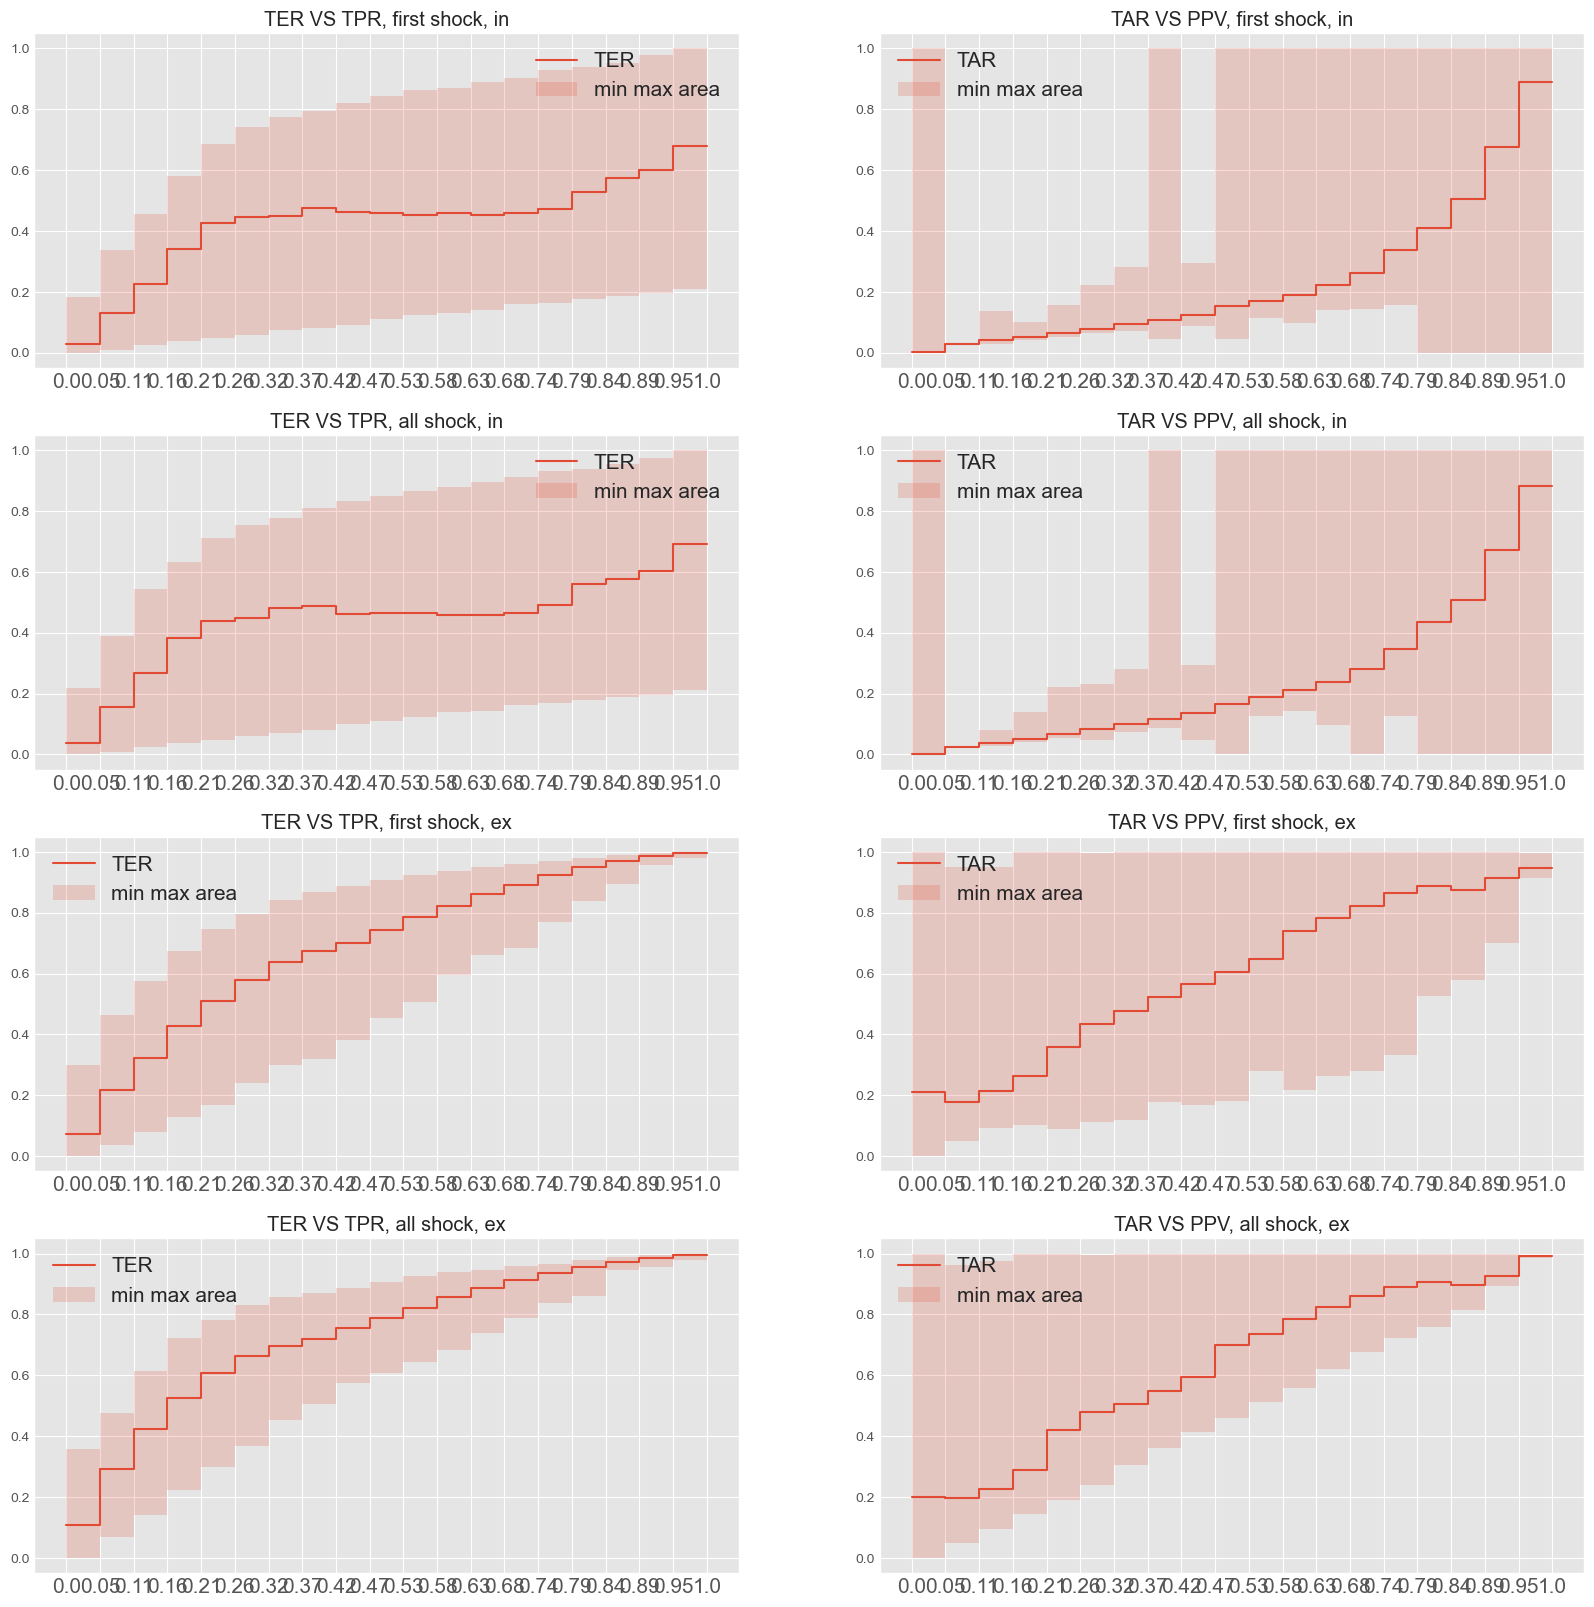

In [8]:
plt.style.use('ggplot')
fig, ax= plt.subplots(4, 2, figsize=(20, 20))
for idx, (edp, fo, p) in enumerate([(a,b,c) for a in [1, 0] for b in [1, 0] for c in ['tpr', 'ppv']]):
    tmp_tpb_eval_df_cf = tpb_eval_df_cf.query(f'eval_during_prolonging == {edp} & first_onset == {fo}')
    # binning 
    p_max = tpb_eval_df_cf[p].max()
    p_min = tpb_eval_df_cf[p].min()

    bin_ranges = np.linspace(p_min, p_max, 20)
    bin_ranges[-1] = 1

    # timeliness 
    for ew in eval_windows[:1]:
        tmp_tlns_eval_df = tlns_eval_df.loc[tlns_eval_df['eval_window'] == ew ].copy()

        tlns = [tmp_tlns_eval_df.loc[tmp_tpb_eval_df_cf.query(f'({p} < {bin_ranges[i+1]}) & ({p} >= {bin_ranges[i]})').index]['TER' if p == 'tpr' else 'TAR'].mean() for i in range(19)]
        tlns.append(tlns[-1])
        tlns_max = [tmp_tlns_eval_df.loc[tmp_tpb_eval_df_cf.query(f'({p} < {bin_ranges[i+1]}) & ({p} >= {bin_ranges[i]})').index]['TER' if p == 'tpr' else 'TAR'].max() for i in range(19)]
        tlns_max.append(tlns_max[-1])
        tlns_min = [tmp_tlns_eval_df.loc[tmp_tpb_eval_df_cf.query(f'({p} < {bin_ranges[i+1]}) & ({p} >= {bin_ranges[i]})').index]['TER' if p == 'tpr' else 'TAR'].min() for i in range(19)]
        tlns_min.append(tlns_min[-1])

        tlns = np.array(tlns)
        tlns_max = np.array(tlns_max)
        tlns_min = np.array(tlns_min)

        nan_idx = np.where(pd.isna(tlns))[0]

        if len(nan_idx) != 0:
            tlns[nan_idx] = np.interp(nan_idx, np.arange(20)[~pd.isna(tlns)], tlns[~pd.isna(tlns)])
            tlns_max[nan_idx] = tlns[nan_idx]
            tlns_min[nan_idx] = tlns[nan_idx]

        ax[idx//2, idx%2].step(bin_ranges, tlns, label=f'{"TER" if p == "tpr" else "TAR"}', linestyle='-', where='post')
        if len(nan_idx) != 0:
            tmp_x = np.append(bin_ranges[nan_idx], [bin_ranges[np.min((nan_idx[-1], 19))]])
            tmp_y = np.append(tlns[nan_idx], tlns[nan_idx][-1])

            ax[idx//2, idx%2].step(tmp_x, tmp_y, label=f'No record', linestyle='-', where='post')
        ax[idx//2, idx%2].fill_between(bin_ranges, np.array(tlns_max), np.array(tlns_min), alpha=0.2, step='post', label='min max area')
        ax[idx//2, idx%2].set_xticks(bin_ranges)
        ax[idx//2, idx%2].set_xticklabels(np.round(bin_ranges, 2), fontsize=15)
        ax[idx//2, idx%2].legend(fontsize=15)
        ax[idx//2, idx%2].set_title(f'{"TER" if p == "tpr" else "TAR"} VS {p.upper()}, {"all shock" if fo == 0 else "first shock"}, {"in" if edp == 1 else "ex"}')

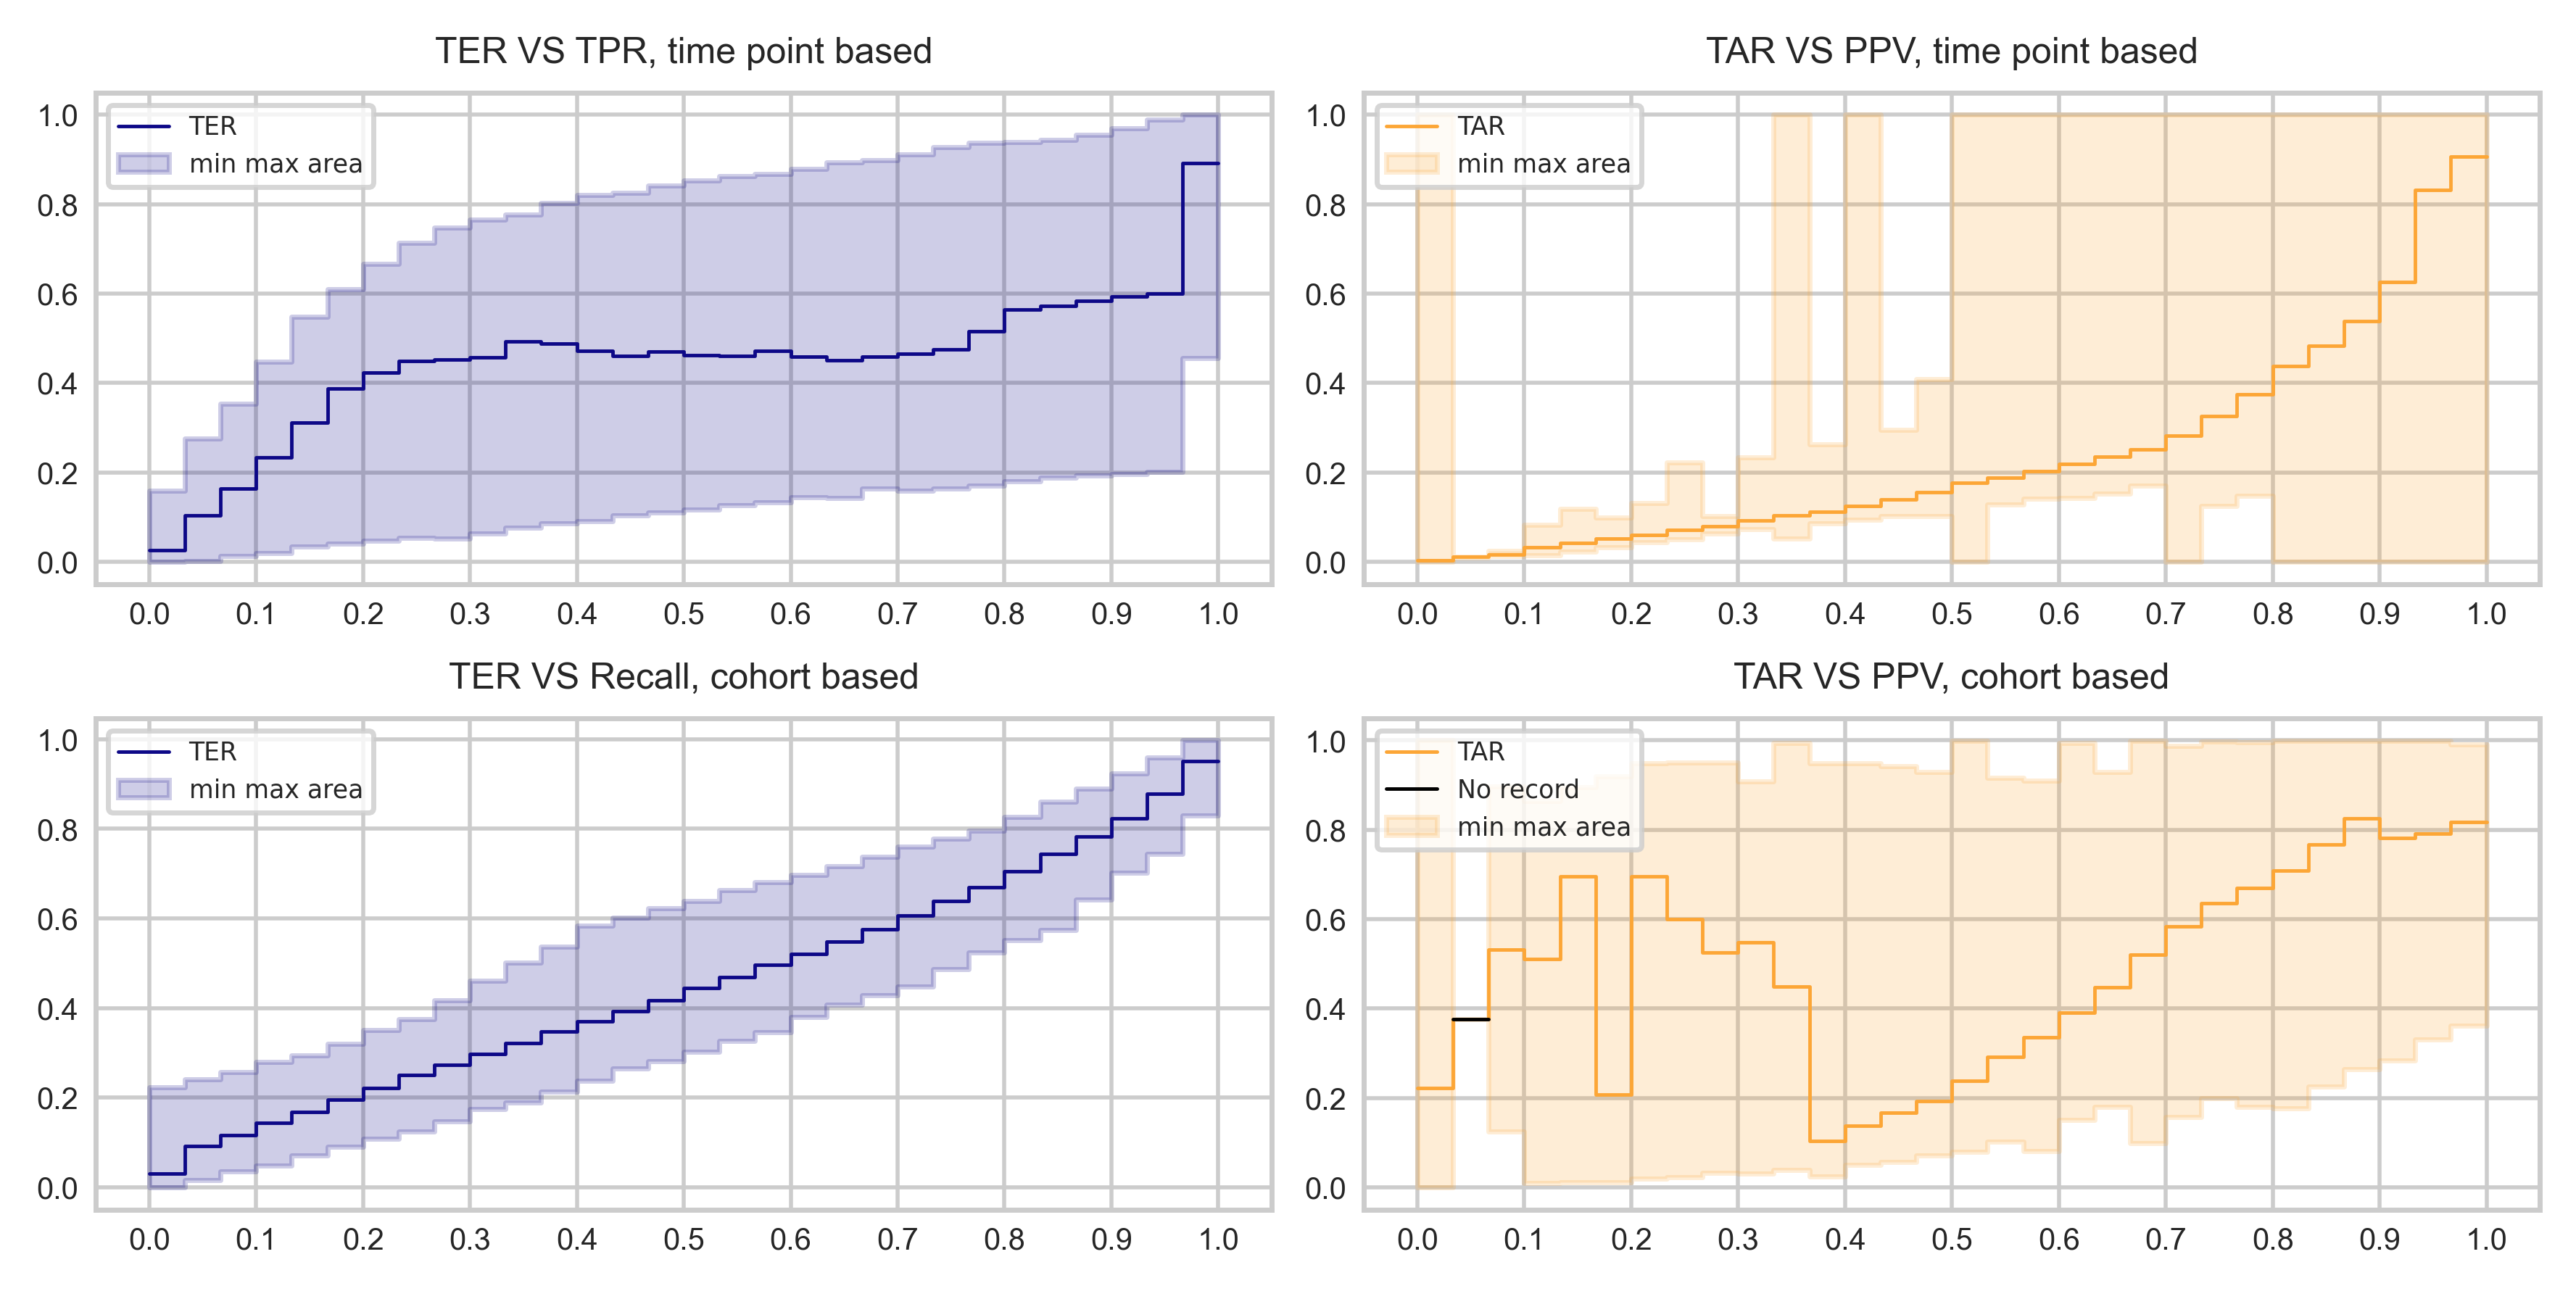

In [55]:
plt.style.use('seaborn-whitegrid')
fig, ax= plt.subplots(2, 2, figsize=(18/2.54, 9/2.54))
plt.rcParams['font.family'] = 'DejaVu Sans'
cmap_name = 'plasma'
plt.rc('font',size=6)
plt.rc('xtick',labelsize=6)
plt.rc('ytick',labelsize=6)
fig.set_dpi(500)
cp = 0.8

for idx, (edp, fo, p) in enumerate([(a,b,c) for a in [1, 0] for b in [0, 1] for c in ['tpr', 'ppv']]):
    if idx > 1:
        break
    tmp_tpb_eval_df_cf = tpb_eval_df_cf.query(f'eval_during_prolonging == {edp} & first_onset == {fo}')

    # binning 
    n_bins = 30
    bin_ranges = np.linspace(0, 1, n_bins+1)

    # timeliness 
    for ew in eval_windows[:1]:
        tmp_tlns_eval_df = tlns_eval_df.loc[tlns_eval_df['eval_window'] == ew].copy()

        tlns = [tmp_tlns_eval_df.loc[tmp_tpb_eval_df_cf.query(f'({p} < {bin_ranges[i+1]}) & ({p} >= {bin_ranges[i]})').index]['TER' if p == 'tpr' else 'TAR'].mean() for i in range(n_bins)]
        tlns.append(tlns[-1])
        tlns_max = [tmp_tlns_eval_df.loc[tmp_tpb_eval_df_cf.query(f'({p} < {bin_ranges[i+1]}) & ({p} >= {bin_ranges[i]})').index]['TER' if p == 'tpr' else 'TAR'].max() for i in range(n_bins)]
        tlns_max.append(tlns_max[-1])
        tlns_min = [tmp_tlns_eval_df.loc[tmp_tpb_eval_df_cf.query(f'({p} < {bin_ranges[i+1]}) & ({p} >= {bin_ranges[i]})').index]['TER' if p == 'tpr' else 'TAR'].min() for i in range(n_bins)]
        tlns_min.append(tlns_min[-1])

        tlns = np.array(tlns)
        tlns_max = np.array(tlns_max)
        tlns_min = np.array(tlns_min)

        nan_idx = np.where(pd.isna(tlns))[0]

        if len(nan_idx) != 0:
            tlns[nan_idx] = np.interp(nan_idx, np.arange(n_bins+1)[~pd.isna(tlns)], tlns[~pd.isna(tlns)])
            tlns_max[nan_idx] = tlns[nan_idx]
            tlns_min[nan_idx] = tlns[nan_idx]

        ax[0, idx%2].step(bin_ranges, tlns, label=f'{"TER" if p == "tpr" else "TAR"}', linestyle='-', where='post', linewidth=0.7, color=plt.cm.get_cmap(cmap_name)(cp*idx))
        if len(nan_idx) != 0:

            tmp_x = np.append(bin_ranges[nan_idx], [bin_ranges[np.min((nan_idx[-1]+1, n_bins))]])
            tmp_y = np.append(tlns[nan_idx], tlns[nan_idx][-1])

            ax[0, idx%2].step(tmp_x, tmp_y, label=f'No record', linestyle='-', where='post', linewidth=0.7, color='black')
        ax[0, idx%2].fill_between(bin_ranges, np.array(tlns_max), np.array(tlns_min), alpha=0.2, step='post', label='min max area', color=plt.cm.get_cmap(cmap_name)(cp*idx))
        ax[0, idx%2].set_xticks([i for idx, i in enumerate(bin_ranges) if idx%3 == 0])
        ax[0, idx%2].set_xticklabels([i for idx, i in enumerate(np.round(bin_ranges, 2)) if idx%3 == 0])
        ax[0, idx%2].legend(frameon=True, fontsize=5)
        ax[0, idx%2].set_title(f'{"TER" if p == "tpr" else "TAR"} VS {p.upper()}, time point based')

for idx, p in enumerate(['tpr', 'ppv']):
    # binning 
    n_bins = 30
    bin_ranges = np.linspace(0, 1, n_bins+1)

    # timeliness 
    for ew in eval_windows[:1]:
        tmp_tlns_eval_df = tlns_eval_df.loc[tlns_eval_df['eval_window'] == ew].copy()

        tlns = [tmp_tlns_eval_df.loc[cb_eval_df.query(f'({p} < {bin_ranges[i+1]}) & ({p} >= {bin_ranges[i]})').index]['TER' if p == 'tpr' else 'TAR'].mean() for i in range(n_bins)]
        tlns.append(tlns[-1])
        tlns_max = [tmp_tlns_eval_df.loc[cb_eval_df.query(f'({p} < {bin_ranges[i+1]}) & ({p} >= {bin_ranges[i]})').index]['TER' if p == 'tpr' else 'TAR'].max() for i in range(n_bins)]
        tlns_max.append(tlns_max[-1])
        tlns_min = [tmp_tlns_eval_df.loc[cb_eval_df.query(f'({p} < {bin_ranges[i+1]}) & ({p} >= {bin_ranges[i]})').index]['TER' if p == 'tpr' else 'TAR'].min() for i in range(n_bins)]
        tlns_min.append(tlns_min[-1])

        tlns = np.array(tlns)
        tlns_max = np.array(tlns_max)
        tlns_min = np.array(tlns_min)

        nan_idx = np.where(pd.isna(tlns))[0]

        if len(nan_idx) != 0:
            tlns[nan_idx] = np.interp(nan_idx, np.arange(n_bins+1)[~pd.isna(tlns)], tlns[~pd.isna(tlns)])
            tlns_max[nan_idx] = tlns[nan_idx]
            tlns_min[nan_idx] = tlns[nan_idx]

        ax[1, idx%2].step(bin_ranges, tlns, label=f'{"TER" if p == "tpr" else "TAR"}', linestyle='-', where='post', linewidth=0.7, color=plt.cm.get_cmap(cmap_name)(cp*idx))
        if len(nan_idx) != 0:
            tmp_x = bin_ranges[nan_idx[0]:nan_idx[-1]+2]
            tmp_y = tlns[nan_idx[0]:nan_idx[-1]+2]
            nan_idx -= nan_idx[0]
            for n_idx in nan_idx:
                if n_idx == nan_idx[0]:
                    ax[1, idx%2].plot(tmp_x[[n_idx, n_idx+1]], tmp_y[[n_idx, n_idx]], label=f'No record', linestyle='-', linewidth=0.7, color='black')
                else:
                    ax[1, idx%2].plot(tmp_x[[n_idx, n_idx+1]], tmp_y[[n_idx, n_idx]], linestyle='-', linewidth=0.7, color='black')
                    
        ax[1, idx%2].fill_between(bin_ranges, np.array(tlns_max), np.array(tlns_min), alpha=0.2, step='post', label='min max area', color=plt.cm.get_cmap(cmap_name)(cp*idx))
        ax[1, idx%2].set_xticks([i for idx, i in enumerate(bin_ranges) if idx%3 == 0])
        ax[1, idx%2].set_xticklabels([i for idx, i in enumerate(np.round(bin_ranges, 2)) if idx%3 == 0])
        ax[1, idx%2].legend(frameon=True, fontsize=5)
        ax[1, idx%2].set_title(f'{"TER" if p == "tpr" else "TAR"} VS {"Recall" if p == "tpr" else "PPV"}, cohort based')
plt.tight_layout()
plt.savefig('paper_figures/TEWS/misalignment_visual.pdf', bbox_inches='tight')

In [80]:
cb_eval_df = cb_eval_df.reset_index().set_index(['pw', 'tw', 'ftf', 'model', 'cutoff'])

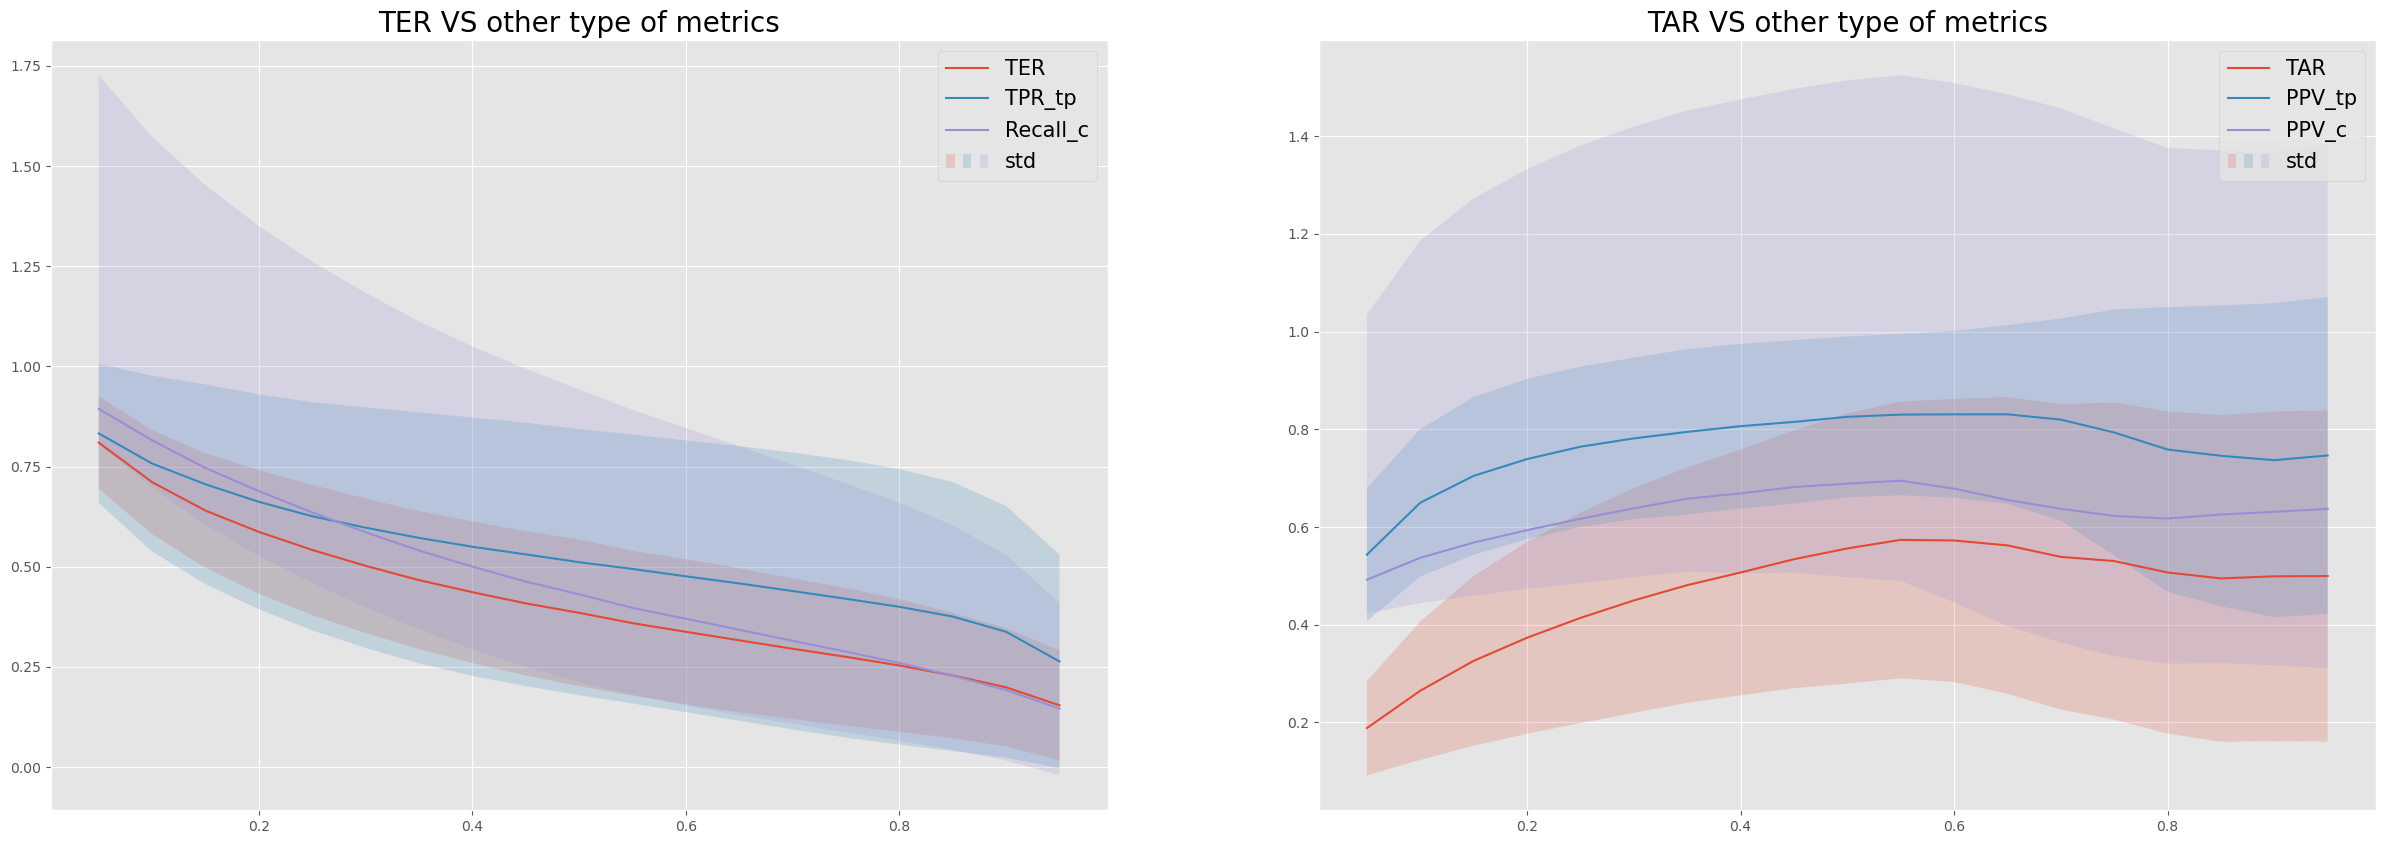

In [82]:
from matplotlib.legend_handler import HandlerTuple
plt.style.use('ggplot')
cutoffs = np.round(np.arange(0.05, 1, 0.05), 2)
fig, ax= plt.subplots(1, 2, figsize=(30, 10))
for idx, (edp, fs, p) in enumerate([(a,b,c) for a in [1, 0] for b in [0, 1] for c in ['tpr', 'ppv']]):
    if idx > 1:
        break
    tmp_tpb_eval_df_cf = tpb_eval_df_cf.query(f'eval_during_prolonging == {edp} & first_onset == {fo}')

    # timeliness 
    for ew in eval_windows[:1]:
        tmp_tlns_eval_df = tlns_eval_df.loc[tlns_eval_df['eval_window'] == ew].copy()

        tlns = [tmp_tlns_eval_df.xs(cf, level='cutoff')['TER' if p == 'tpr' else 'TAR'].mean() for cf in cutoffs]
        tlns_std = [tmp_tlns_eval_df.xs(cf, level='cutoff')['TER' if p == 'tpr' else 'TAR'].std() for cf in cutoffs]
        p_evals = [tmp_tpb_eval_df_cf.xs(cf, level='cutoff')[p].mean() for cf in cutoffs]
        p_std = [tmp_tpb_eval_df_cf.xs(cf, level='cutoff')[p].std() for cf in cutoffs]
        cb_evals = [cb_eval_df.xs(cf, level='cutoff')[p].mean() for cf in cutoffs]
        cb_std = [cb_eval_df.xs(cf, level='cutoff')[p].std() for cf in cutoffs]

        line1, = ax[idx%2].plot(cutoffs, tlns, label=f'{"TER" if p == "tpr" else "TAR"}', linestyle='-')
        std1 = ax[idx%2].fill_between(cutoffs, np.array(tlns)+np.array(tlns_std), np.array(tlns)-np.array(tlns_std), alpha=0.2, label='std 1')

        line2, = ax[idx%2].plot(cutoffs, p_evals, label=f'{p.upper()}_tp', linestyle='-')
        std2 = ax[idx%2].fill_between(cutoffs, np.array(p_evals)+np.array(p_std), np.array(p_evals)-np.array(p_std), alpha=0.2, label='std 2')

        line3, = ax[idx%2].plot(cutoffs, cb_evals, label=f'{"Recall_c" if p == "tpr" else "PPV_c"}', linestyle='-')
        std3 = ax[idx%2].fill_between(cutoffs, np.array(p_evals)+np.array(cb_evals), np.array(cb_evals)-np.array(cb_std), alpha=0.2, label='std 3')


        # Create the legend
        legend_handler = HandlerTuple(ndivide=None)
        legend_handles = [(line1), (line2), (line3), (std1, std2, std3)]
        ax[idx%2].legend(handles=legend_handles, labels=[f'{"TER" if p == "tpr" else "TAR"}', f'{p.upper()}_tp', f'{"Recall_c" if p == "tpr" else "PPV_c"}', 'std'], handler_map={tuple: legend_handler}, fontsize=15)
        
        ax[idx%2].set_title(f'{"TER" if p == "tpr" else "TAR"} VS other type of metrics', fontsize=20)

## variation

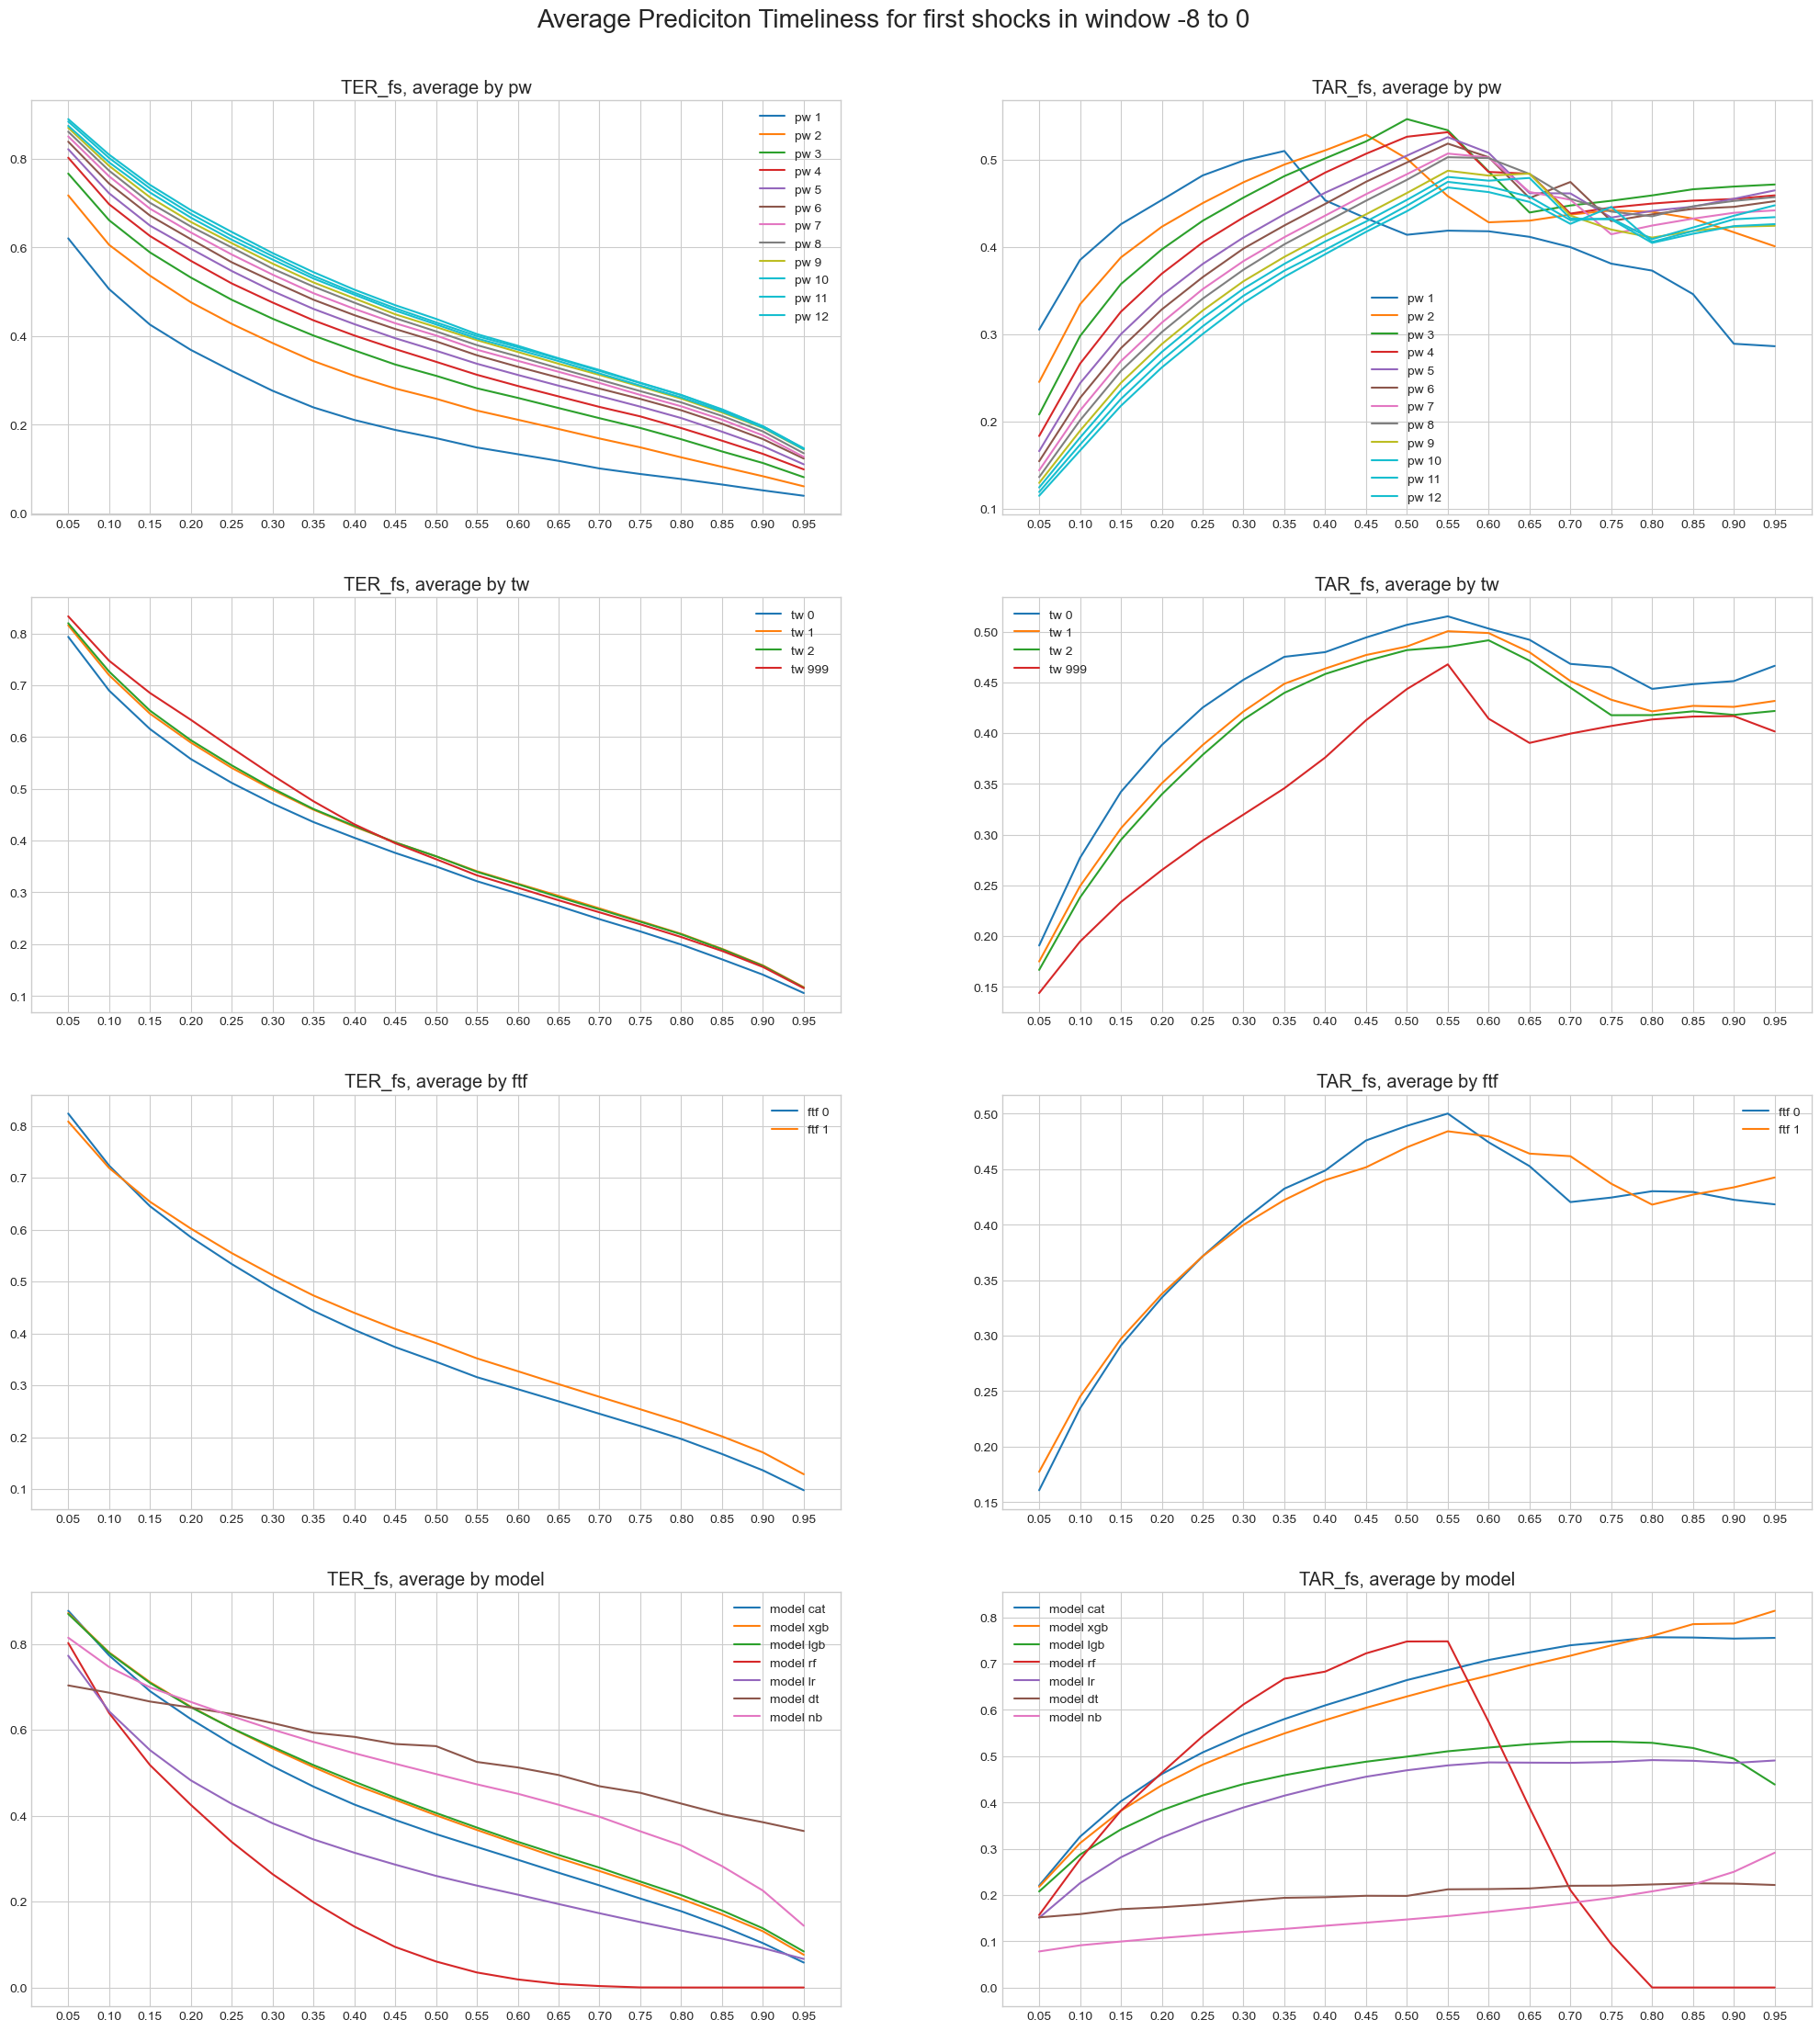

In [28]:
plt.style.use('seaborn-whitegrid')
cmap_name = 'tab10'
tlns_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_tlns_{seed}.csv')
tlns_eval_df = tlns_eval_df.loc[tlns_eval_df.cutoff.isin(np.round(np.arange(0.05, 1, 0.05), 2))]
eval_windows = tlns_eval_df.eval_window.unique().tolist()

tmp_tlns_eval_df = tlns_eval_df.query(f'eval_window == "ew_8_0"')

eval_metrics = ['TER_fs', 'TAR_fs']
fig, ax= plt.subplots(4,2,figsize=(25, 25))
for idx_mtr ,mtr in enumerate(eval_metrics):
    for idx_fct, avg_by in enumerate(['pw', 'tw', 'ftf', 'model']):
        tmp_tlns_avg = tmp_tlns_eval_df.groupby([avg_by, 'cutoff'])[mtr].mean().unstack()
        factors = tmp_tlns_eval_df[avg_by].unique()
        for idx, i in enumerate(factors):
            ax[idx_fct, idx_mtr].plot(tmp_tlns_avg.loc[i], label = f'{avg_by} {i}', color=plt.cm.get_cmap(cmap_name)(idx))
            ax[idx_fct, idx_mtr].set_xticks(tmp_tlns_avg.columns)
            ax[idx_fct, idx_mtr].legend(fontsize=10)
            ax[idx_fct, idx_mtr].set_title(f'{mtr}, average by {avg_by}')

fig.suptitle(f'Average Prediciton Timeliness for first shocks in window -8 to 0', size=20)
fig.subplots_adjust(top=0.94)

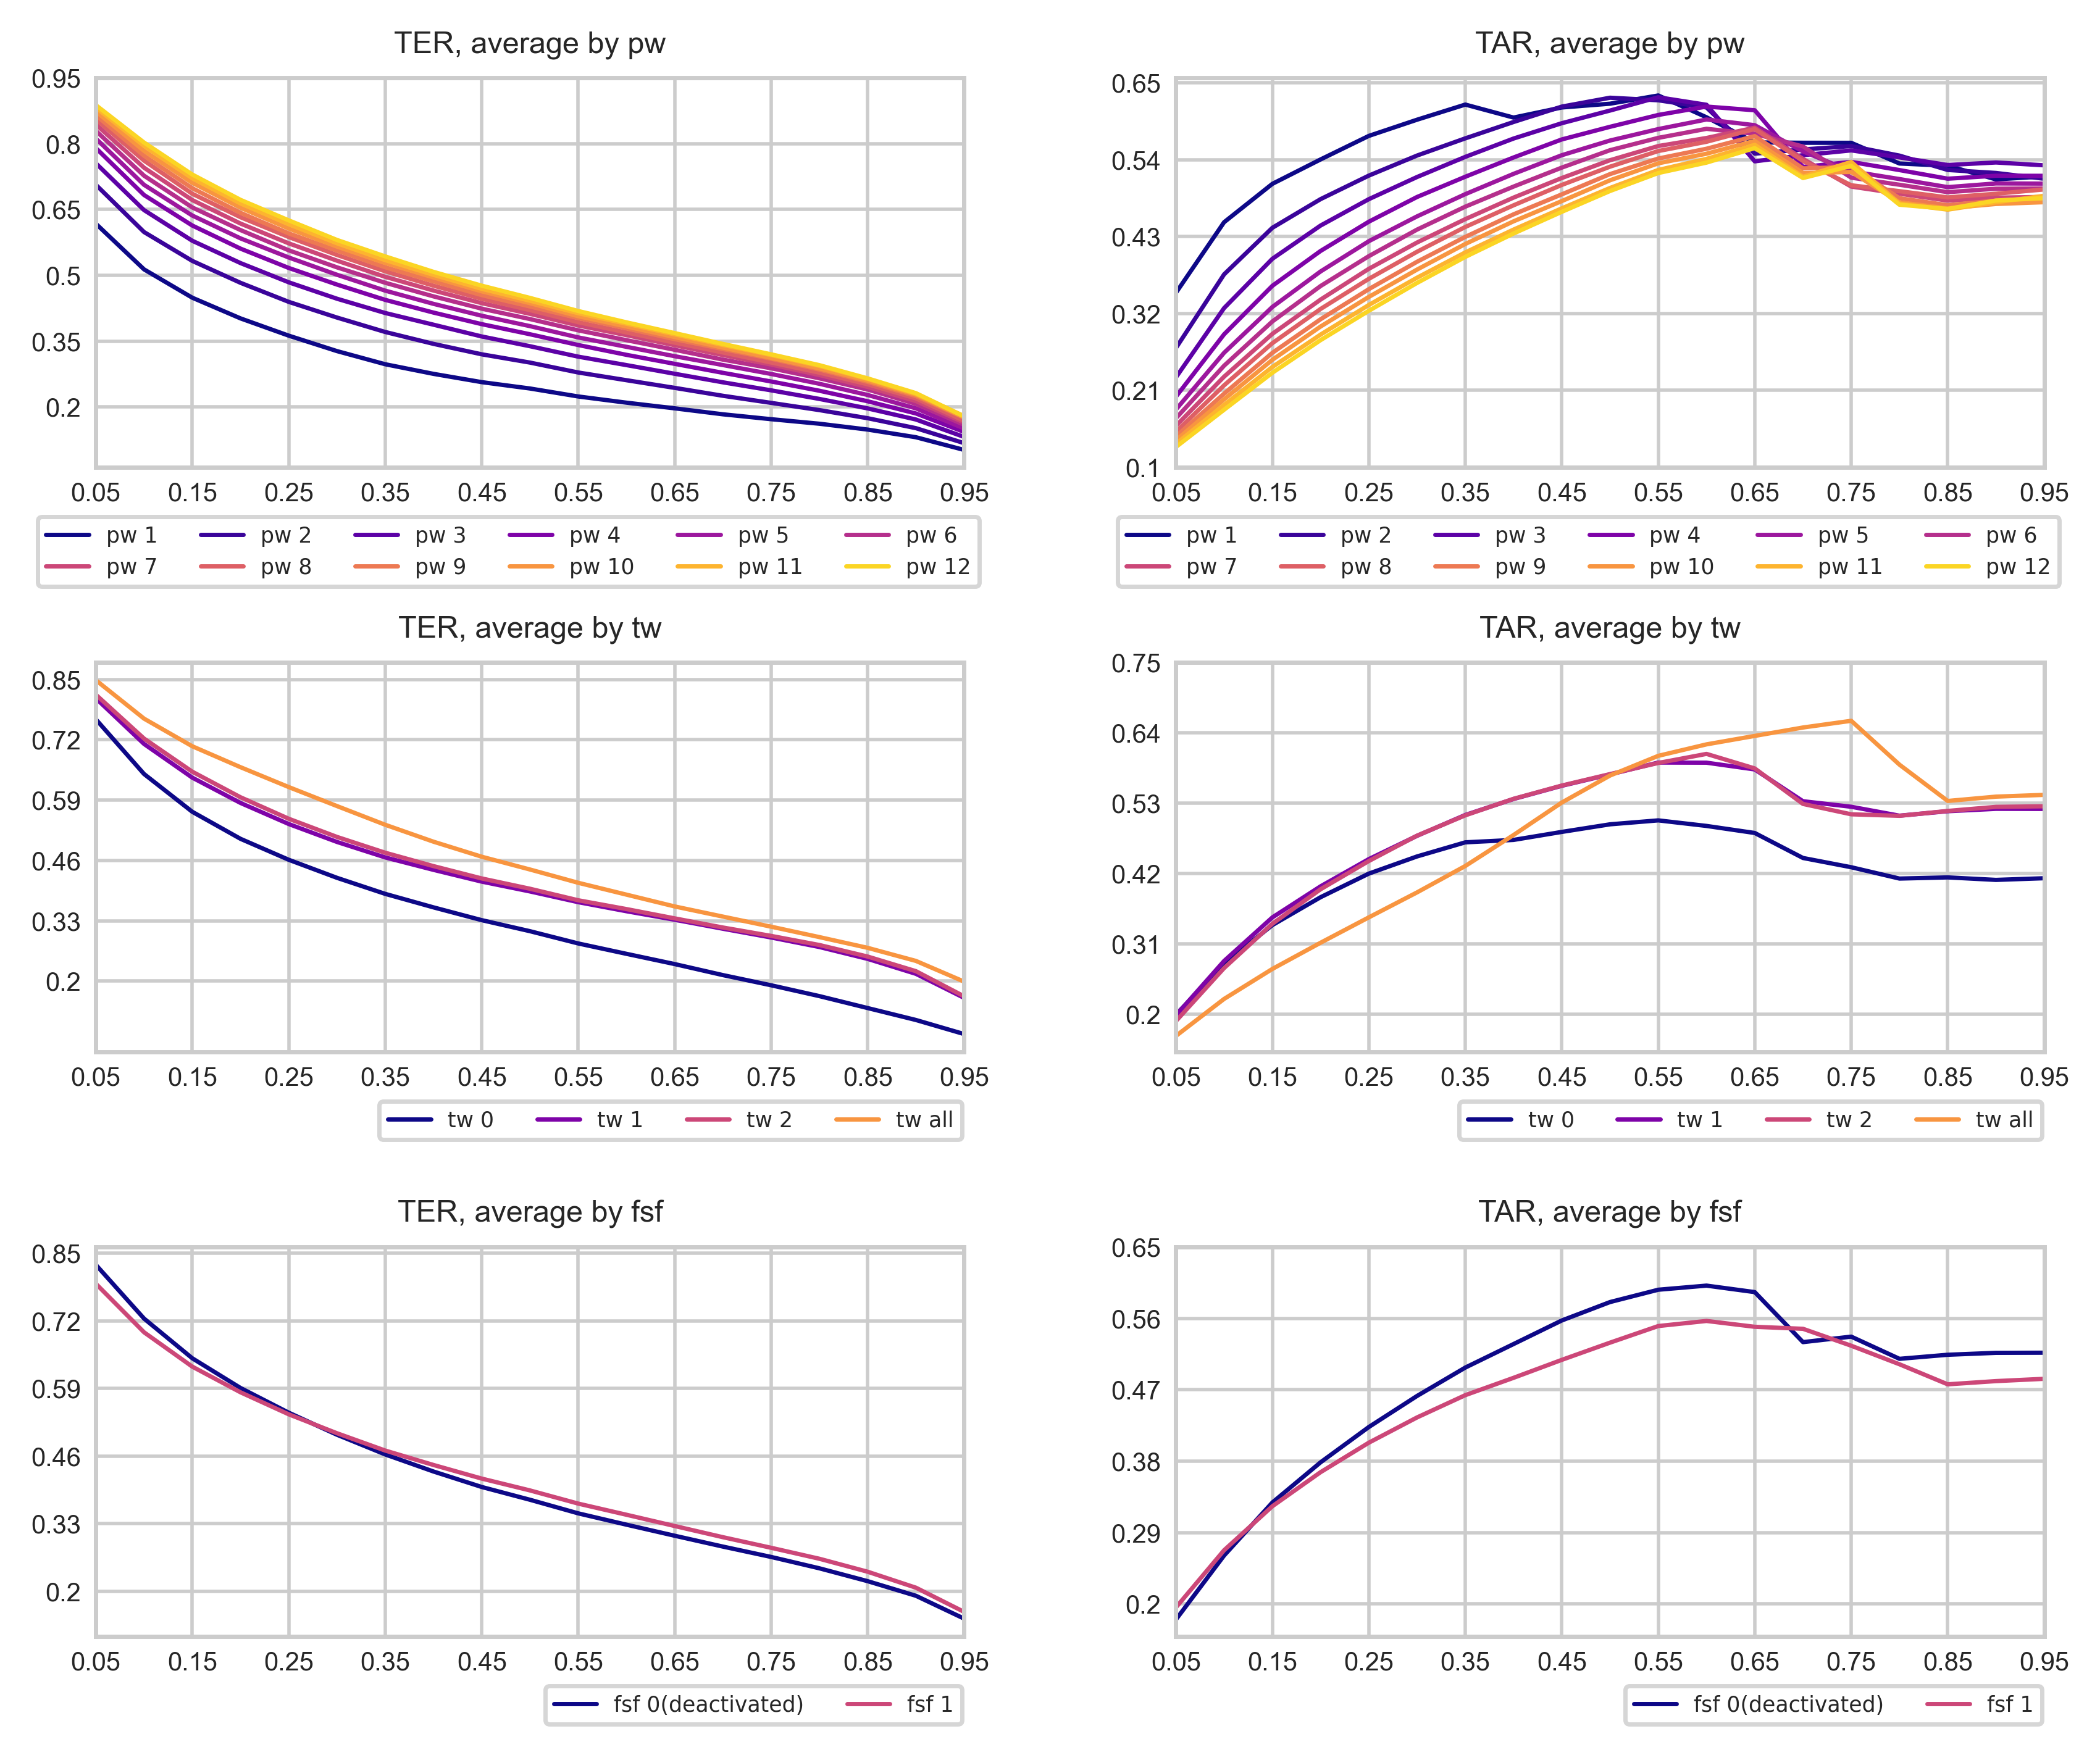

In [66]:
plt.style.use('seaborn-whitegrid')
cmap_name = 'plasma'
tlns_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_tlns_{seed}.csv')
tlns_eval_df = tlns_eval_df.loc[tlns_eval_df.cutoff.isin(np.round(np.arange(0.05, 1, 0.05), 2))]
eval_windows = tlns_eval_df.eval_window.unique().tolist()

tmp_tlns_eval_df = tlns_eval_df.query(f'eval_window == "ew_8_0"')

eval_metrics = ['TER', 'TAR']
fig, ax= plt.subplots(3,2,figsize=(18/2.54, 14.4/2.54))
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rc('font',size=6)
plt.rc('xtick',labelsize=6)
plt.rc('ytick',labelsize=6)
fig.set_dpi(500)
for idx_mtr, mtr in enumerate(eval_metrics):
    for idx_fct, avg_by in enumerate(['pw', 'tw', 'ftf']):
        tmp_tlns_avg = tmp_tlns_eval_df.groupby([avg_by, 'cutoff'])[mtr].mean().unstack()
        factors = tmp_tlns_eval_df[avg_by].unique()

        for idx, i in enumerate(factors):
            label = f'{avg_by} {i}'
            if avg_by == 'ftf':
                avg_by = 'fsf'
                label = f'fsf {i}({"deactivated" if i == 0 else "activated"})'
            elif avg_by == 'tw':
                label = f'tw {"all" if i == 999 else i}'

            ax[idx_fct, idx_mtr].plot(tmp_tlns_avg.loc[i], label = label, color=plt.cm.get_cmap(cmap_name)(1/len(factors)*idx), linewidth=1)
            ax[idx_fct, idx_mtr].set_xticks([i for idx, i in enumerate(tmp_tlns_avg.columns) if idx%2 == 0])
            ax[idx_fct, idx_mtr].set_xticklabels([i for idx, i in enumerate(tmp_tlns_avg.columns) if idx%2 == 0])
            
            y_max = np.round(tmp_tlns_avg.loc[i].max(), 1)
            y_min = np.round(tmp_tlns_avg.loc[i].min(), 1)

            ax[idx_fct, idx_mtr].set_yticks(np.round(np.linspace(y_min, y_max+0.05, 6),2))
            ax[idx_fct, idx_mtr].set_yticklabels(np.round(np.linspace(y_min, y_max+0.05, 6),2))
            ax[idx_fct, idx_mtr].set_xlim(0.05, 0.95)

        if avg_by == 'pw':
            handles, labels = ax[idx_fct, idx_mtr].get_legend_handles_labels()
            order = [0,6,1,7,2,8,3,9,4,10,5,11]
            ax[idx_fct, idx_mtr].legend([handles[j] for j in order], [labels[j] for j in order], fontsize=5, frameon=True, bbox_to_anchor=(1.03,-0.1), ncol=6) 

        else:
            ax[idx_fct, idx_mtr].legend(fontsize=5, frameon=True, bbox_to_anchor=(1.01,-0.1), ncol=6)
        ax[idx_fct, idx_mtr].set_title(f'{mtr}, average by {avg_by}', fontsize=7)

plt.tight_layout()

plt.savefig('paper_figures/TEWS/variation.pdf', bbox_inches='tight')

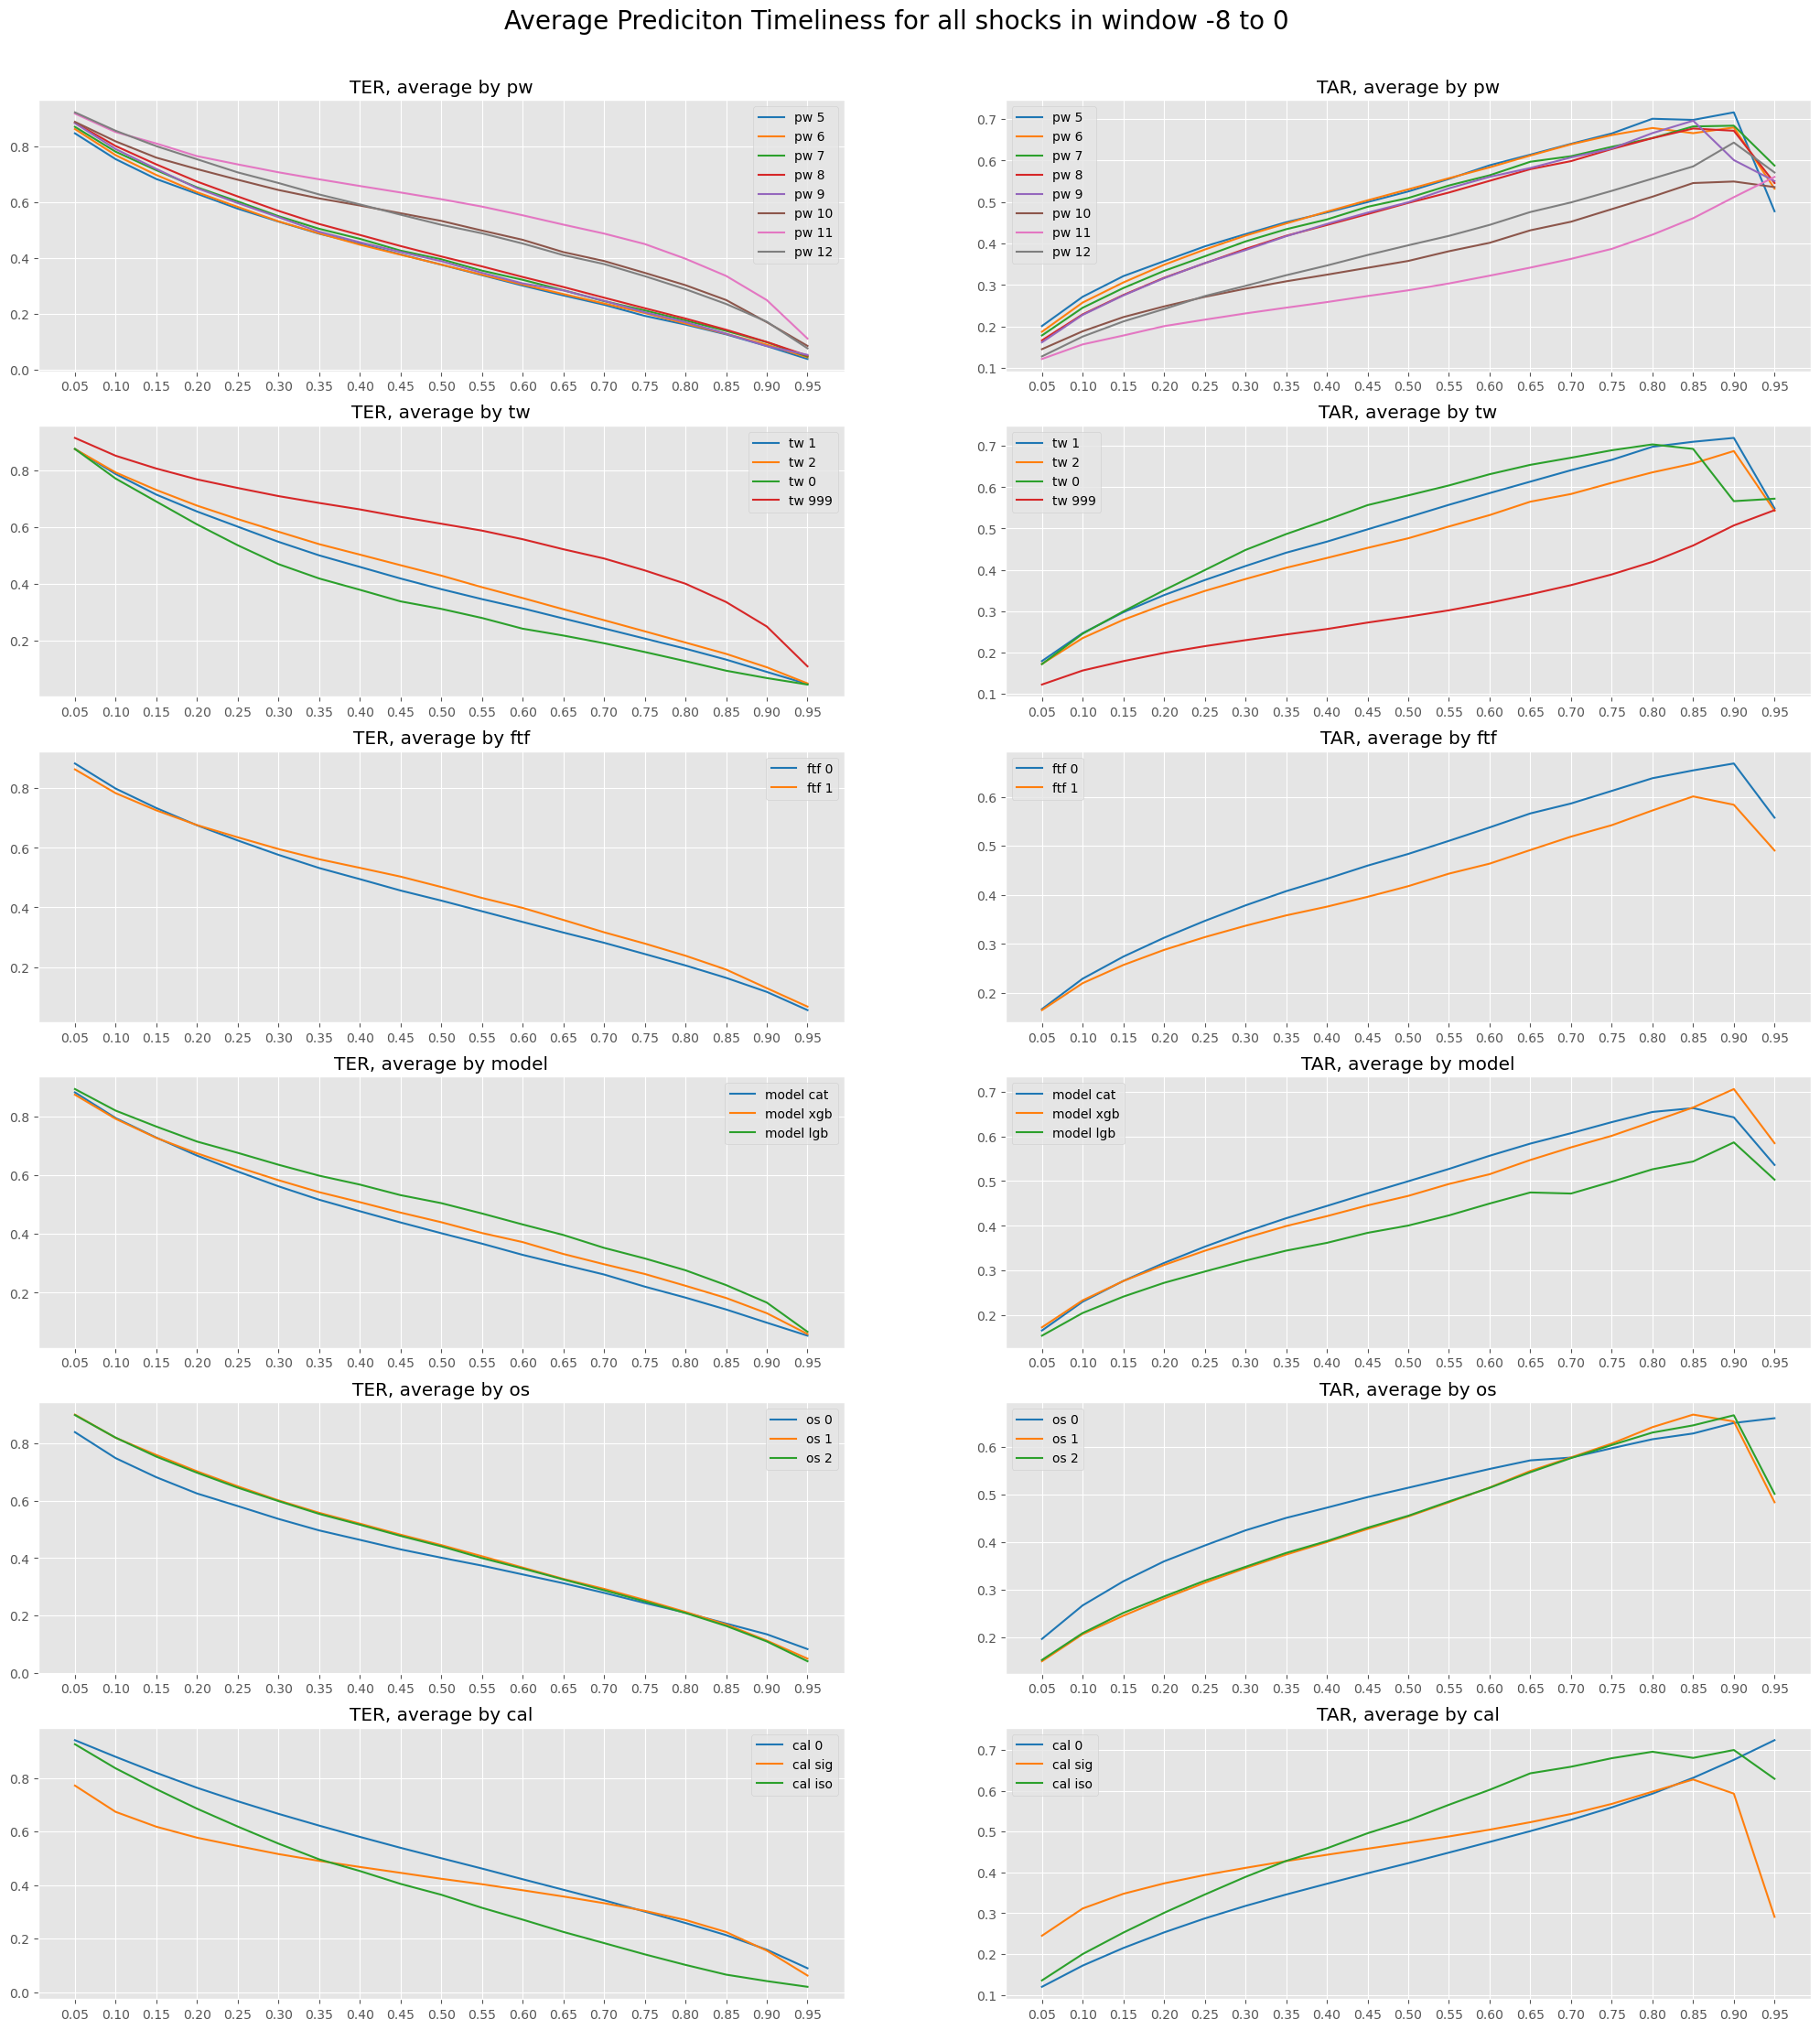

In [113]:
tlns_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_tlns_{seed}_oscal_r85_p15_tpb.csv')
plt.style.use('ggplot')
cmap_name = 'tab10'
cutoffs = np.round(np.arange(0.05, 1, 0.05), 2)

tmp_tlns_eval_df = tlns_eval_df.query(f'eval_window == "ew_8_0"')

eval_metrics = ['TER', 'TAR']
fig, ax= plt.subplots(6,2,figsize=(25, 25))
for idx_mtr ,mtr in enumerate(eval_metrics):
    for idx_fct, avg_by in enumerate(['pw', 'tw', 'ftf', 'model', 'os', 'cal']):
        tmp_tlns_avg = tmp_tlns_eval_df.groupby([avg_by, 'cutoff'])[mtr].mean().unstack()
        factors = tmp_tlns_eval_df[avg_by].unique()
        for idx, i in enumerate(factors):
            ax[idx_fct, idx_mtr].plot(tmp_tlns_avg.loc[i], label = f'{avg_by} {i}', color=plt.cm.get_cmap(cmap_name)(idx))
            ax[idx_fct, idx_mtr].set_xticks(tmp_tlns_avg.columns)
            ax[idx_fct, idx_mtr].legend(fontsize=10)
            ax[idx_fct, idx_mtr].set_title(f'{mtr}, average by {avg_by}')

fig.suptitle(f'Average Prediciton Timeliness for all shocks in window -8 to 0', size=20)
fig.subplots_adjust(top=0.94)

## failure cases

In [4]:
def timeliness(x, criteria={'from': [-8], 'to':[0]}):
    if (x['target'].sum() == 0):
        repetition = len(criteria['from'])*len(criteria['to'])
        return np.repeat([[np.nan, np.nan, np.nan, 0, 0, x['alarm'].sum(), x['alarm'].sum()]], repetition, axis=0).ravel() # EWP 계산에만 산입
    
    else:
        if (x['alarm'].sum() == 0):
            repetition = len(criteria['from'])*len(criteria['to'])
            t_idx = np.sort(x[x['target']==1].index)

            tmp_t_idx = [t_idx[0]]
            t_onset_idx = [t_idx[0]]
            for i in t_idx[1:]:
                if (i - tmp_t_idx[-1]) > 1:
                    t_onset_idx.append(i)

                tmp_t_idx.append(i)

            return np.repeat([[0, 0, len(t_onset_idx), 0, 0, 0, 0]], repetition, axis=0).ravel() # 이 경우 (ewr, ewp)_stay = 0 
        
        else:
            t_idx = np.sort(x[x['target']==1].index)
            a_idx = np.sort(x[x['alarm']==1].index)

            oe_pairs = []
            tmp_oe = [t_idx[0]]
            for idx in t_idx:
                if (idx - tmp_oe[-1]) > 1:
                    oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
                    tmp_oe = []
                tmp_oe.append(idx)
            oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
            t_onset_idx = np.array(oe_pairs)[:, 0]
            t_end_idx = np.array(oe_pairs)[:, 1]

            results = []            
            for f, t in [(a, b) for a in criteria['from'] for b in criteria['to']]:
                tmp_result = [0 for _ in range(7)]
                tmp_result[2] = len(t_onset_idx)

                # all shock
                tt_num = 0
                ta = []
                for i in t_onset_idx:
                    tmp_ta = a_idx[(a_idx<(i+t))&(a_idx>=(i+f))].tolist()
                    if len(tmp_ta) > 0:
                        tt_num += 1
                        ta += tmp_ta
                ta = list(set(ta))
                tmp_result[0] = tt_num
                tmp_result[3] = len(ta)
                
                fa_idx = set(a_idx)-set(ta)
                fa_idx = set(fa_idx)-set(t_idx)
                tmp_result[5] = len(fa_idx) + len(ta)

                # first shock
                tt_num = 0
                ta = []
                tmp_ta = a_idx[(a_idx<(t_idx[0]+t))&(a_idx>=(t_idx[0]+f))].tolist()
                if len(tmp_ta) > 0:
                    tt_num += 1
                    ta += tmp_ta
                tmp_result[1] = tt_num
                tmp_result[4] = len(ta)
                tmp_result[6] = len(a_idx[a_idx<(t_idx[0]+t)])

                results += tmp_result
                
            return results

def timeliness_eval_ens(model_settings, exp_setting, data, risk_dict, seed, voting, cutoffs=np.round(np.arange(0.05, 1, 0.05), 2), adj_option='mm'):
    target_col = ['SHOCK']
    data.columns = [i if i not in target_col else 'target' for i in data.columns]

    print(f'{voting} ensembling....', sep=' ')
    if voting == 'hard':
        alarms = []
        for mdlst in tqdm(model_settings):
            # risk score loading
            if exp_setting.__contains__('oscal'):
                pw, tw, ftf, mdl, os, cal, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_os{os}_cal{cal}_seed{seed}'
            else:
                pw, tw, ftf, mdl, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
            
            data['risk_score'] = risk_dict[key_name]
            tmp_data = data.loc[data[f'split_{seed}']=='tst', ['risk_score']].dropna()
            tmp_data['alarm'] = np.where(tmp_data['risk_score'] >= cf, 1, 0)

            alarms.append(tmp_data['alarm'].tolist())
        
        alarms = np.array(alarms).mean(axis=0)
        print('done')

    elif voting == 'soft':
        risks = []
        for mdlst in tqdm(model_settings):
            # risk score loading
            if exp_setting.__contains__('oscal'):
                pw, tw, ftf, mdl, os, cal, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_os{os}_cal{cal}_seed{seed}'
            else:
                pw, tw, ftf, mdl, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
                
            data['risk_score'] = risk_dict[key_name]
            tmp_data = data.loc[data[f'split_{seed}']=='tst', ['risk_score']].dropna()
            risks.append(tmp_data['risk_score'].tolist())

        risks = np.array(risks)
        risk_maxs = risks.max(axis=1).reshape(-1,1)
        risk_mins = risks.min(axis=1).reshape(-1,1)
        risk_mus = risks.mean(axis=1).reshape(-1,1)
        risk_stds = risks.std(axis=1).reshape(-1,1)

        if adj_option == 'mm':
            adjusted_risks = (risks-risk_mins)/(risk_maxs-risk_mins)
        elif adj_option == 'ss':
            adjusted_risks = (risks-risk_mus)/(risk_stds)
            adjusted_risks = (adjusted_risks-adjusted_risks.min())/(adjusted_risks.max()-adjusted_risks.min())
        else:
            adjusted_risks = risks

        adjusted_risks = adjusted_risks.mean(axis=0)

        print('done')

    else:
        return 'error! error!'

    eval_results = []
    tmp_data = data.loc[data[f'split_{seed}']=='tst', ['stay_id', 'target', 'risk_score']].dropna()

    print('evaluating....', sep=' ')
    for cf in tqdm(cutoffs):
        if voting == 'hard':
            tmp_data['alarm'] = np.where(alarms > cf, 1, 0)
        elif voting == 'soft':
            tmp_data['risk_score'] = adjusted_risks
            tmp_data['alarm'] = np.where(tmp_data['risk_score'] > cf, 1, 0)

        ver = ['_8_0']

        tlns_result = pd.DataFrame(tmp_data.groupby(['stay_id']).apply(timeliness).to_list(), columns=[b+a 
                                                                                                        for a in ver 
                                                                                                        for b in ['att', 'ftt', 'at', 'ata', 'fta', 'aa', 'faa']]) 
        

        for i in range(len(ver)):
            tmp_tlns_result = tlns_result.iloc[:,i*7:(i+1)*7]
            tmp = tmp_tlns_result.sum().to_numpy()
            tmp_no_na = tmp_tlns_result.dropna()
            
            tmp_eval = [cf, 'ew'+ver[i]]
            tmp_eval += [tmp[0]/tmp[2], # EWR
                            tmp[3]/tmp[5] if tmp[5] !=0 else 0, # EWP
                            tmp[1]/tmp_no_na.shape[0], # EWR_fs
                            tmp[4]/tmp[6] if tmp[6] !=0 else 0] # EWP_fs
                        
            
            tmp = tmp_no_na.eval(f'ewr_stay = att{ver[i]}/at{ver[i]}').mean()
            tmp_eval += [tmp['ewr_stay']]

            tmp = tmp_no_na.eval(f'ewp_stay = ata{ver[i]}/aa{ver[i]}')
            tmp['ewp_stay'] = [i if i >=0 else 0 for i in tmp['ewp_stay']]
            tmp_eval += [tmp['ewp_stay'].mean()]

            tmp = tmp_no_na.eval(f'ewp_f_stay = fta{ver[i]}/faa{ver[i]}')
            tmp['ewp_f_stay'] = [i if i >=0 else 0 for i in tmp['ewp_f_stay']]
            tmp_eval += [tmp['ewp_f_stay'].mean()]
                
            eval_results.append(tmp_eval)

    print('done')
    return eval_results

In [5]:
seed = 230726
seed = f'{seed}_wage'
exp_setting= '_r90_p19_tpb_oscal'

with open(f'sepsis_data_risk_dict_{seed}{exp_setting}.pkl', 'rb') as f:
    risk_dict = pickle.load(f)
seed = 230726
tlns_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_tlns_{seed}{exp_setting}.csv')

In [ ]:
def eval_single(data, risk_dict, seed, trst=(9, 1, 0, 'xgb', 2, '0'), cutoffs=np.round(np.arange(0.05, 1, 0.01), 2)):
    pw, tw, ftf, mdl, os, cal = trst
    key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_os{os}_cal{cal}_seed{seed}'
    data['risk_score'] = risk_dict[key_name]
    tmp_data = data.loc[data[f'split_{seed}']=='tst', :].copy()
    ver = ['_8_0']

    eval_result = []
    for cf in cutoffs:
        tmp_data['alarm'] = np.where(tmp_data['risk_score'] >= cf, 1, 0)

        tlns_result = pd.DataFrame(tmp_data.groupby(['stay_id']).apply(timeliness).to_list(), columns=[b+a for a in ver for b in ['att', 'ftt', 'at', 'ata', 'fta', 'aa', 'faa']]) 

        for i in range(len(ver)):
            tmp_tlns_result = tlns_result.iloc[:,i*7:(i+1)*7]
            tmp = tmp_tlns_result.sum().to_numpy()
            tmp_no_na = tmp_tlns_result.dropna()
            
            tmp_eval = [cf, 'ew'+ver[i]]
            tmp_eval += [tmp[0]/tmp[2], # EWR
                            tmp[3]/tmp[5] if tmp[5] !=0 else 0, # EWP
                            tmp[1]/tmp_no_na.shape[0], # EWR_fs
                            tmp[4]/tmp[6] if tmp[6] !=0 else 0] # EWP_fs
                        
            
            tmp = tmp_no_na.eval(f'ewr_stay = att{ver[i]}/at{ver[i]}').mean()
            tmp_eval += [tmp['ewr_stay']]

            tmp = tmp_no_na.eval(f'ewp_stay = ata{ver[i]}/aa{ver[i]}')
            tmp['ewp_stay'] = [i if i >=0 else 0 for i in tmp['ewp_stay']]
            tmp_eval += [tmp['ewp_stay'].mean()]

            tmp = tmp_no_na.eval(f'ewp_f_stay = fta{ver[i]}/faa{ver[i]}')
            tmp['ewp_f_stay'] = [i if i >=0 else 0 for i in tmp['ewp_f_stay']]
            tmp_eval += [tmp['ewp_f_stay'].mean()]
                
            eval_result.append(tmp_eval)

    return eval_result


eval_result = eval_single(data.copy(), risk_dict, seed, trst=(9, 1, 0, 'xgb', 2, '0'))
col_names = ['cutoff', 'eval_window', 'TER', 'TAR', 'TER_fs', 'TAR_fs', 'TER_stay', 'TAR_stay', 'TAR_fs_stay']
eval_df = pd.DataFrame(eval_result, columns=col_names)
eval_df

In [6]:
threshold = {
    'TER': 0.91,
    'TAR': 0.195
}

eval_windows = ['ew_8_0']

tlns_cand = tlns_eval_df.loc[tlns_eval_df['eval_window'].isin(eval_windows)].query(f'TER>{threshold["TER"]} & TAR>{threshold["TAR"]}')
if exp_setting.__contains__('oscal'):
    model_settings = tlns_cand.loc[:, ['pw', 'tw', 'ftf', 'model', 'os', 'cal', 'cutoff']].drop_duplicates().to_numpy()
else:
    model_settings = tlns_cand.loc[:, ['pw', 'tw', 'ftf', 'model', 'cutoff']].drop_duplicates().to_numpy()
tlns_cand

,pw,tw,ftf,model,os,cal,cutoff,eval_window,TER,TAR,TER_fs,TAR_fs,TER_stay,TAR_stay,TAR_fs_stay
200,3,1,0,cat,0,iso,0.03,ew_8_0,0.914920,0.195438,0.922197,0.176924,0.915119,0.405995,0.705916
1287,3,1,0,xgb,1,sig,0.01,ew_8_0,0.914920,0.195805,0.903890,0.179059,0.908001,0.384880,0.692485
1584,3,1,0,xgb,2,sig,0.01,ew_8_0,0.913687,0.200037,0.908467,0.181480,0.913738,0.389469,0.694317
2675,3,2,0,xgb,0,0,0.03,ew_8_0,0.911221,0.208858,0.913043,0.190856,0.912559,0.427389,0.703960
2874,3,2,0,xgb,0,iso,0.04,ew_8_0,0.911221,0.210184,0.913043,0.192057,0.912559,0.428983,0.705086
3366,3,2,0,xgb,2,sig,0.01,ew_8_0,0.914920,0.195177,0.910755,0.179214,0.918320,0.386133,0.694599
4457,3,999,0,xgb,0,0,0.03,ew_8_0,0.912454,0.202470,0.913043,0.187023,0.915078,0.413606,0.704385
4755,3,999,0,xgb,1,0,0.04,ew_8_0,0.922318,0.197243,0.913043,0.182400,0.919252,0.404061,0.706934
4851,3,999,0,xgb,1,sig,0.01,ew_8_0,0.914920,0.204560,0.903890,0.188967,0.911774,0.408790,0.702176
5845,4,1,0,cat,1,iso,0.05,ew_8_0,0.911221,0.200335,0.903890,0.182339,0.904285,0.388094,0.685123


In [7]:
for ver in range(3):
    ens_method = [('hard', None), ('soft', 'ss'), ('soft', 'mm')]
    voting, adj_option = ens_method[ver]
    eval_result = timeliness_eval_ens(model_settings, exp_setting, data.copy(), risk_dict, seed, voting=voting, adj_option=adj_option, cutoffs=np.round(np.arange(0.01, 1, 0.01), 2))

    col_names = ['cutoff', 'eval_window', 'TER', 'TAR', 'TER_fs', 'TAR_fs', 'TER_stay', 'TAR_stay', 'TAR_fs_stay']
    ens_eval_df = pd.DataFrame(eval_result, columns=col_names)
    ens_eval_df.to_csv(f'processed_data/sepsis/eval_modeling/eval_tlns_{seed}_tst_v{ver}.csv', index=False)

hard ensembling....


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


done
evaluating....


100%|██████████| 99/99 [00:34<00:00,  2.86it/s]


done
soft ensembling....


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


done
evaluating....


100%|██████████| 99/99 [00:31<00:00,  3.15it/s]


done
soft ensembling....


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


done
evaluating....


100%|██████████| 99/99 [00:31<00:00,  3.10it/s]

done


In [8]:
def cb_true_pred(x):
    positive = int(x['target'].sum() > 0)
    
    if positive == 0:
        prediction = int(x['alarm'].sum() > 0)
    else:
        first_onset = x[x['target']==1].index[0]
        prediction = int(x['alarm'].loc[:(first_onset-1)].sum() > 0)

    return positive, prediction

def conf_mat(true, pred):
    tp = ((pred == 1) & (true == 1)).sum()
    fp = ((pred == 1) & (true == 0)).sum()
    fn = ((pred == 0) & (true == 1)).sum()
    tn = ((pred == 0) & (true == 0)).sum()

    return tp, fp, fn, tn

from sklearn.metrics import auc

def cbm_evaluation(training_setting, data, risk_dict, seed, approx):
    # prediction timeliness eval
    target_col = ['SHOCK']
    data.columns = [i if i not in target_col else 'target' for i in data.columns]
        
    pw, tw, ftf, mdl = training_setting
    # risk score loading
    key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
    data['risk_score'] = risk_dict[key_name]
    tmp_data = data.loc[data[f'split_{seed}']=='val', ['stay_id']+['target']+['risk_score']].dropna()
    
    cut_offs = np.linspace(tmp_data['risk_score'].min(), tmp_data['risk_score'].max(), approx)

    eval_result = [pw, tw, ftf, mdl]
    tmp_eval_result = []
    for cf in tqdm(cut_offs):
        tmp_data['alarm'] = np.where(tmp_data['risk_score'] >= cf, 1, 0)
        cbm_result = pd.DataFrame(tmp_data.groupby(['stay_id']).apply(cb_true_pred).to_list(), columns=['pos', 'pred'])

        tp, fp, fn, tn = conf_mat(cbm_result['pos'], cbm_result['pred'])

        tpr = tp/(tp+fn)
        ppv = tp/(tp+fp) if tp+fp != 0 else 0
        tnr = tn/(tn+fp) if tn+fp != 0 else 0
        npv = fn/(tn+fn) if tn+fn != 0 else 0
        acc = (tp+tn)/(tp+fp+fn+tn)
        f1 = 2*tp/(fp+2*tp+fn)
        tmp_eval_result.append([tpr, ppv, tnr, npv, acc, f1])

    tmp_eval_result = np.array(tmp_eval_result)
    x, y = 1-tmp_eval_result[:, 2], tmp_eval_result[:, 0]

    selected = tmp_eval_result[(y == np.sort(y)[approx//2])][0]
    selected = list(selected)
    selected += [auc(x, y)]
    eval_result += selected


def cb_eval_ens(model_settings, exp_setting, data, risk_dict, seed, voting, adj_option, cf_type='naive', approx=None, cutoffs=None):
    target_col = ['SHOCK']
    data.columns = [i if i not in target_col else 'target' for i in data.columns]

    print(f'{voting} ensembling....', sep=' ')
    if voting == 'hard':
        alarms = []
        for mdlst in tqdm(model_settings):
            # risk score loading
            if exp_setting.__contains__('oscal'):
                pw, tw, ftf, mdl, os, cal, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_os{os}_cal{cal}_seed{seed}'
            else:
                pw, tw, ftf, mdl, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
            
            data['risk_score'] = risk_dict[key_name]
            tmp_data = data.loc[data[f'split_{seed}']=='tst', ['risk_score']].dropna()
            tmp_data['alarm'] = np.where(tmp_data['risk_score'] >= cf, 1, 0)

            alarms.append(tmp_data['alarm'].tolist())
        
        alarms = np.array(alarms).mean(axis=0)
        print('done')

    elif voting == 'soft':
        risks = []
        for mdlst in tqdm(model_settings):
            # risk score loading
            if exp_setting.__contains__('oscal'):
                pw, tw, ftf, mdl, os, cal, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_os{os}_cal{cal}_seed{seed}'
            else:
                pw, tw, ftf, mdl, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
                
            data['risk_score'] = risk_dict[key_name]
            tmp_data = data.loc[data[f'split_{seed}']=='tst', ['risk_score']].dropna()
            risks.append(tmp_data['risk_score'].tolist())

        risks = np.array(risks)
        risk_maxs = risks.max(axis=1).reshape(-1,1)
        risk_mins = risks.min(axis=1).reshape(-1,1)
        risk_mus = risks.mean(axis=1).reshape(-1,1)
        risk_stds = risks.std(axis=1).reshape(-1,1)

        if adj_option == 'mm':
            adjusted_risks = (risks-risk_mins)/(risk_maxs-risk_mins)
        elif adj_option == 'ss':
            adjusted_risks = (risks-risk_mus)/(risk_stds)
            adjusted_risks = (adjusted_risks-adjusted_risks.min())/(adjusted_risks.max()-adjusted_risks.min())
        else:
            adjusted_risks = risks

        adjusted_risks = adjusted_risks.mean(axis=0)

        print('done')

    else:
        return 'error! error!'

    eval_results = []
    tmp_data = data.loc[data[f'split_{seed}']=='tst', ['stay_id', 'target', 'risk_score']].dropna()
    if cf_type == 'strict':
        cutoffs = np.unique(tmp_data['risk_score'])
    elif cf_type == 'approx':
        cutoffs = np.linspace(tmp_data['risk_score'].min(), tmp_data['risk_score'].max(), approx)
    elif cf_type == 'naive':
        cutoffs = cutoffs

    print('evaluating....', sep=' ')
    for cf in tqdm(cutoffs):
        if voting == 'hard':
            tmp_data['alarm'] = np.where(alarms > cf, 1, 0)
        elif voting == 'soft':
            tmp_data['risk_score'] = adjusted_risks
            tmp_data['alarm'] = np.where(tmp_data['risk_score'] > cf, 1, 0)

        cbm_result = pd.DataFrame(tmp_data.groupby(['stay_id']).apply(cb_true_pred).to_list(), columns=['pos', 'pred'])

        tp, fp, fn, tn = conf_mat(cbm_result['pos'], cbm_result['pred'])

        tpr = tp/(tp+fn)
        ppv = tp/(tp+fp) if tp+fp != 0 else 0
        tnr = tn/(tn+fp) if tn+fp != 0 else 0
        npv = fn/(tn+fn) if tn+fn != 0 else 0
        acc = (tp+tn)/(tp+fp+fn+tn)
        f1 = 2*tp/(fp+2*tp+fn)

        eval_results.append([cf, tpr, ppv, tnr, npv, acc, f1])

    print('done')
    return eval_results

In [9]:
eval_result = cb_eval_ens(model_settings, exp_setting, data.copy(), risk_dict, seed, voting='hard', adj_option=None, cf_type='naive', cutoffs=[0.28])

col_names = ['cutoff', 'tpr', 'ppv', 'tnr', 'npv', 'acc', 'f1']
ens_eval_df_cb = pd.DataFrame(eval_result, columns=col_names)
ens_eval_df_cb

hard ensembling....


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


done
evaluating....


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

done


,cutoff,tpr,ppv,tnr,npv,acc,f1
0,0.28,0.965675,0.514634,0.462888,0.041899,0.649406,0.67144


In [11]:
ens_eval_df_cb.to_csv('tmp.csv', index=False)

In [10]:
def TEW3S_tstdf(model_settings, exp_setting, data, risk_dict, seed, cutoff=0.30, voting='soft', adj_option='ss'):
    target_col = ['SHOCK']
    data.columns = [i if i not in target_col else 'target' for i in data.columns]

    print(f'{voting} ensembling....', sep=' ')
    if voting == 'hard':
        alarms = []
        for mdlst in tqdm(model_settings):
            # risk score loading
            if exp_setting.__contains__('oscal'):
                pw, tw, ftf, mdl, os, cal, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_os{os}_cal{cal}_seed{seed}'
            else:
                pw, tw, ftf, mdl, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
            
            data['risk_score'] = risk_dict[key_name]
            tmp_data = data.loc[data[f'split_{seed}']=='tst', ['risk_score']].dropna()
            tmp_data['alarm'] = np.where(tmp_data['risk_score'] >= cf, 1, 0)

            alarms.append(tmp_data['alarm'].tolist())
        
        alarms = np.array(alarms).mean(axis=0)
        print('done')

    elif voting == 'soft':
        risks = []
        for mdlst in tqdm(model_settings):
            # risk score loading
            if exp_setting.__contains__('oscal'):
                pw, tw, ftf, mdl, os, cal, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_os{os}_cal{cal}_seed{seed}'
            else:
                pw, tw, ftf, mdl, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
                
            data['risk_score'] = risk_dict[key_name]
            tmp_data = data.loc[data[f'split_{seed}']=='tst', ['risk_score']].dropna()
            risks.append(tmp_data['risk_score'].tolist())

        risks = np.array(risks)
        risk_maxs = risks.max(axis=1).reshape(-1,1)
        risk_mins = risks.min(axis=1).reshape(-1,1)
        risk_mus = risks.mean(axis=1).reshape(-1,1)
        risk_stds = risks.std(axis=1).reshape(-1,1)

        if adj_option == 'mm':
            adjusted_risks = (risks-risk_mins)/(risk_maxs-risk_mins)
        elif adj_option == 'ss':
            adjusted_risks = (risks-risk_mus)/(risk_stds)
            adjusted_risks = (adjusted_risks-adjusted_risks.min())/(adjusted_risks.max()-adjusted_risks.min())
        else:
            adjusted_risks = risks

        adjusted_risks = adjusted_risks.mean(axis=0)

        print('done')

    else:
        return 'error! error!'
    
    tmp_data = data.loc[data[f'split_{seed}']=='tst', :].copy()
    if voting == 'hard':
        tmp_data['alarm'] = np.where(alarms > cutoff, 1, 0)
    elif voting == 'soft':
        tmp_data['risk_score'] = adjusted_risks
        tmp_data['alarm'] = np.where(tmp_data['risk_score'] > cutoff, 1, 0)

    print('done')
    return tmp_data

In [11]:
tst_df = TEW3S_tstdf(model_settings, exp_setting, data.copy(), risk_dict, seed, cutoff=0.28, voting='hard')

hard ensembling....


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


done
done


In [12]:
core_variables = [i+'_value' for i in core_list]+['SOFA']+['ventilator_value', 'vaso_presence', 'fluid_value']

In [13]:
def failure_cases(x):
    if (x['target'].sum() == 0):
        if (x['alarm'].sum() != 0):
        
            a_idx = np.sort(x[x['alarm']==1].index)
            tmp_cond = (x.vaso_presence > 0)|(x.fluid_value > 0)
            i_idx = np.sort(x.loc[tmp_cond].index)

            ia_num = 0
            for tmp in a_idx:
                if (np.sum((i_idx <= tmp+1)&(i_idx >= tmp-1))) > 0:
                    ia_num += 1
            
            
            return [1, len(a_idx), ia_num] + x.loc[a_idx, core_variables].mean().tolist() + [0 for i in range(len(core_variables)+3)]


    else:
        if (x['alarm'].sum() == 0):
            t_idx = np.sort(x[x['target']==1].index)

            oe_pairs = []
            tmp_oe = [t_idx[0]]
            for idx in t_idx:
                if (idx - tmp_oe[-1]) > 1:
                    oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
                    tmp_oe = []
                tmp_oe.append(idx)
            oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
            t_onset_idx = np.array(oe_pairs)[:, 0]
            t_end_idx = np.array(oe_pairs)[:, 1]

            td = t_onset_idx-np.append([x.index[0]], t_end_idx[:-1])

            if len(td) > 1:
                td[1:] = td[1:]-1

            na_idx = []
            for idx in t_onset_idx:
                na_idx += list(np.arange(np.max([x.index[0], idx-8]), idx))

            return [0 for i in range(len(core_variables)+3)] + [1, len(t_onset_idx), np.mean(td)] + x.loc[na_idx, core_variables].mean().tolist()
        
        else:
            t_idx = np.sort(x[x['target']==1].index)
            a_idx = np.sort(x[x['alarm']==1].index)
            tmp_cond = (x.vaso_presence > 0)|(x.fluid_value > 0)
            i_idx = np.sort(x.loc[tmp_cond].index)

            oe_pairs = []
            tmp_oe = [t_idx[0]]
            for idx in t_idx:
                if (idx - tmp_oe[-1]) > 1:
                    oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
                    tmp_oe = []
                tmp_oe.append(idx)
            oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
            t_onset_idx = np.array(oe_pairs)[:, 0]
            t_end_idx = np.array(oe_pairs)[:, 1]

            results = []
            f = -8
            t = 0       

            # all shock
            tt_num = 0
            ta = []
            nto_idx = []
            nte_idx = []
            na_idx = []
            for idx, i in enumerate(t_onset_idx):
                tmp_ta = a_idx[(a_idx<(i+t))&(a_idx>=(i+f))].tolist()
                if len(tmp_ta) == 0:
                    nto_idx += [i]
                    nte_idx += [t_end_idx[idx]]
                    na_idx += list(np.arange(np.max([x.index[0], i-8]), i))
                else:
                    ta += tmp_ta
            ta = list(set(ta))
            fa_idx = set(a_idx)-set(ta)
            fa_idx = set(fa_idx)-(set(t_idx))
            fa_idx = list(fa_idx)

            td = np.array(nto_idx)-np.append([x.index[0]], nte_idx[:-1])
            
            if len(td) > 1:
                td[1:] = td[1:]-1
                
            ia_num = 0
            for tmp in fa_idx:
                if (np.sum((i_idx <= tmp+1)&(i_idx >= tmp-1))) > 0:
                    ia_num += 1
            
            return [int(len(fa_idx)>0), len(fa_idx), ia_num] + x.loc[fa_idx, core_variables].mean().tolist() + [int(len(nto_idx)>0), len(nto_idx), np.mean(td)] + x.loc[na_idx, core_variables].mean().tolist()

In [14]:
f_analysis = tst_df.groupby('stay_id').apply(failure_cases)

c:\Users\KyuminKim\anaconda3\envs\torch_py39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\KyuminKim\anaconda3\envs\torch_py39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\KyuminKim\anaconda3\envs\torch_py39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\KyuminKim\anaconda3\envs\torch_py39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\KyuminKim\anaconda3\envs\torch_py39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\KyuminKim\anaconda3\envs\torch_py39\lib\site-packages\numpy\core\_

In [15]:
fca_df = pd.DataFrame(f_analysis.dropna().tolist())
fca_df.columns = ['fa', 'n_fa', 'n_ia'] + [i+'_fa' for i in core_variables] + ['na', 'n_na', 'td'] + [i+'_na' for i in core_variables]

In [16]:
fca_df_fa = fca_df.query('fa==1').iloc[:,:18]
fca_df_na = fca_df.query('na==1').iloc[:,18:]

In [17]:
fca_df_fa['n_ia'].sum()/fca_df_fa['n_fa'].sum()

0.9431912653106468

In [28]:
fca_df_fa.iloc[:,5:].mean().to_csv('fa_mean.csv')

In [87]:
fca_df_na.td.describe(np.arange(0.05, 1, 0.05))

count     90.000000
mean     117.711111
std      143.223523
min        1.000000
5%         1.000000
10%        2.000000
15%        9.000000
20%       13.733333
25%       26.125000
30%       32.400000
35%       42.150000
40%       46.600000
45%       60.100000
50%       65.500000
55%       71.475000
60%       82.200000
65%       98.925000
70%      123.500000
75%      133.000000
80%      210.800000
85%      259.850000
90%      291.550000
95%      430.000000
max      684.000000
Name: td, dtype: float64

In [29]:
sum(fca_df_na.td<12)/fca_df_na.shape[0]

0.1320754716981132

In [24]:
fca_df_na.loc[fca_df_na.td<12].td.mean()

5.0

In [ ]:
fca_df_na.loc[fca_df_na.td>24*7]

In [65]:
(sum(fca_df_na.td>24*7)-4)/fca_df_na.shape[0]

0.17777777777777778

In [59]:
fca_df_na.loc[fca_df_na.td>24*7].td.mean()

344.35

In [60]:
sum(fca_df_na.td>24*14)/fca_df_na.shape[0]

0.07777777777777778

In [61]:
fca_df_na.loc[fca_df_na.td>24*14].td.mean()

504.42857142857144

In [30]:
fca_df_na.iloc[:,5:].mean().to_csv('na_mean.csv')

In [26]:
na_stays = f_analysis.dropna().index[fca_df_na.index].tolist()
fa_stays = f_analysis.dropna().index[fca_df_fa.index].tolist()

In [27]:
df_f_mm = data.join(tst_df['alarm'])
df_f_mm = df_f_mm.loc[:, ['target', 'SEPSIS']+core_variables+['alarm']]
df_f_mm = (df_f_mm-df_f_mm.min())/(df_f_mm.max()-df_f_mm.min())
df_f_mm['stay_id'] = data['stay_id']

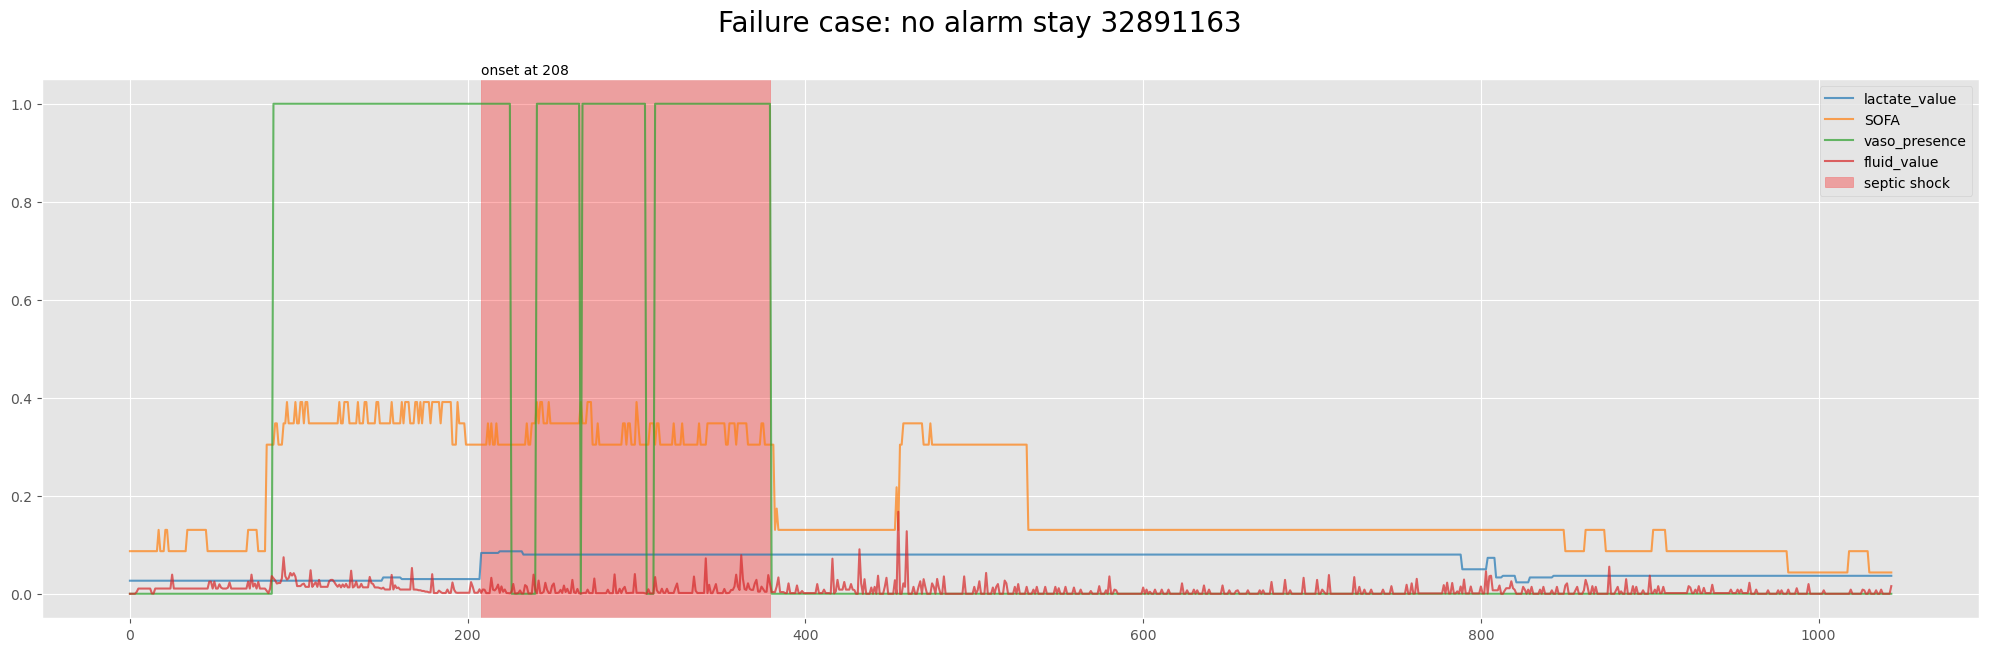

In [28]:
na_stay_df = df_f_mm.query(f'stay_id == {na_stays[16]}')
plt.style.use('ggplot')
cmap_name = 'tab10'

fig, ax = plt.subplots(figsize=(25, 7))

tmp_df = na_stay_df.copy().reset_index(drop=True)

col_names = ['lactate_value', 'SOFA', 'vaso_presence', 'fluid_value']

for idx, col in enumerate(col_names): 
    ax.plot(tmp_df[col], label = f'{col}', color=plt.cm.get_cmap(cmap_name)(idx), alpha=0.7)

ax.axvspan(tmp_df.index[tmp_df.target==1][0], tmp_df.index[tmp_df.target==1][-1], alpha=0.3, color='red', label='septic shock')
ax.text(tmp_df.index[tmp_df.target==1][0], 1.06, f'onset at {tmp_df.index[tmp_df.target==1][0]}', size=10)

ax.legend()
fig.suptitle(f'Failure case: no alarm stay {na_stay_df.stay_id.iloc[0]}', size=20)
fig.subplots_adjust(top=0.88)

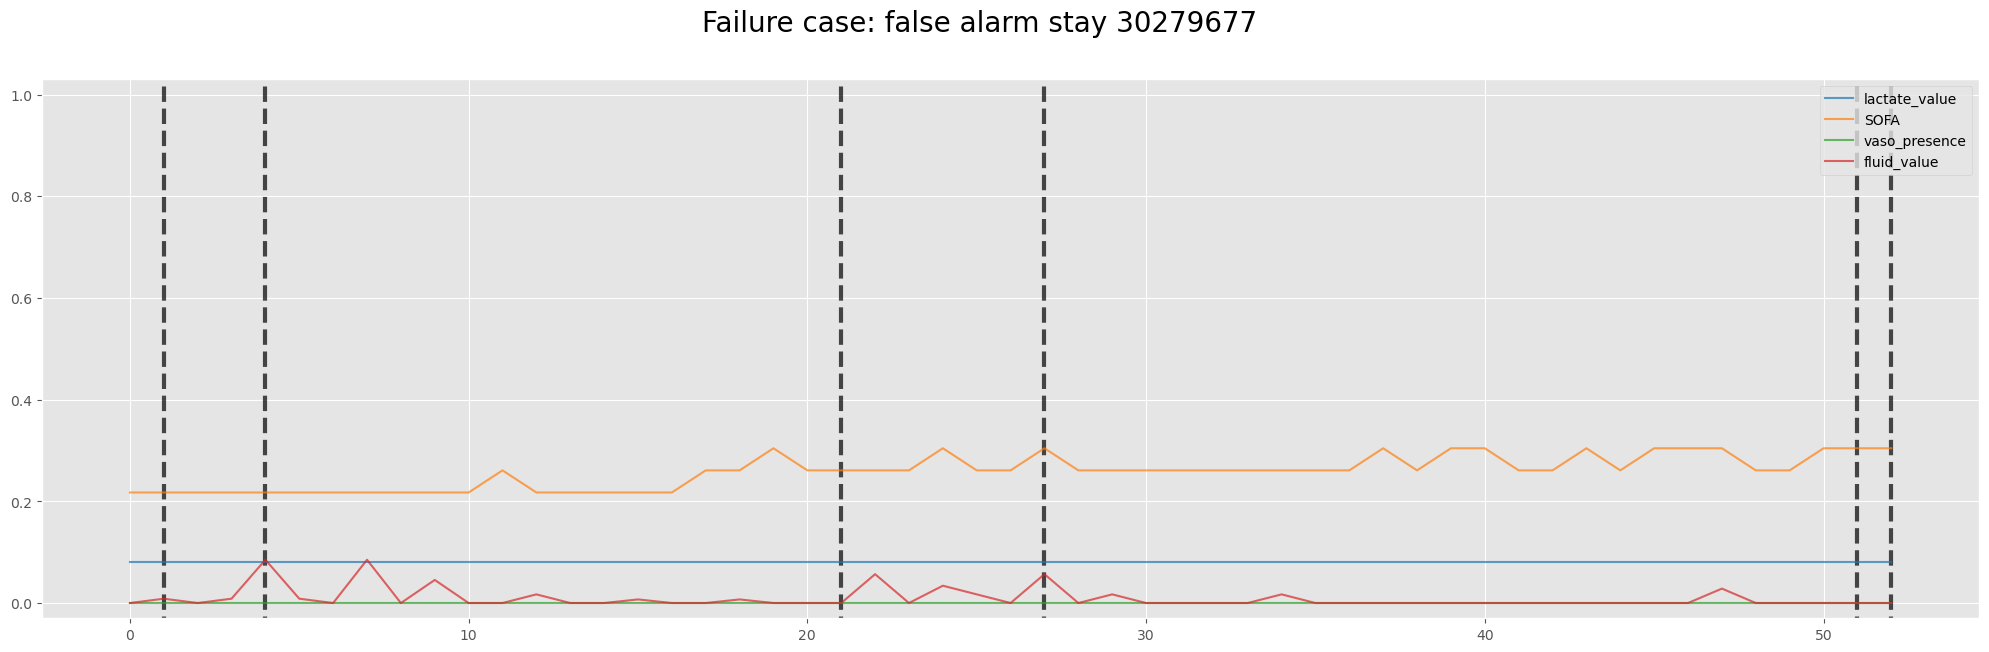

In [29]:
fa_stay_df = df_f_mm.query(f'stay_id == {fa_stays[21]}')
plt.style.use('ggplot')
cmap_name = 'tab10'
fig, ax = plt.subplots(figsize=(25, 7))

tmp_df = fa_stay_df.copy().reset_index(drop=True)

a_idx = tmp_df.index[tmp_df.alarm==1]
t_idx = tmp_df.index[tmp_df.target==1]
if len(t_idx) > 0: 
    oe_pairs = []
    tmp_oe = [t_idx[0]]
    for idx in t_idx:
        if (idx - tmp_oe[-1]) > 1:
            oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
            tmp_oe = []
        tmp_oe.append(idx)
    oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
    t_onset_idx = np.array(oe_pairs)[:, 0]
    t_end_idx = np.array(oe_pairs)[:, 1]
    
    ta = []

    for t in t_onset_idx:
        tmp_ta = a_idx[(a_idx<(t))&(a_idx>=(t-8))]
        ta += tmp_ta.tolist()

    ta = list(set(ta))
    fa_idx = set(a_idx)-set(ta)
    fa_idx = set(fa_idx)-(set(t_idx))
    fa_idx = list(fa_idx)
else:
    fa_idx = a_idx

col_names = ['lactate_value', 'SOFA', 'vaso_presence', 'fluid_value']

if len(t_idx) > 0: 
    for i in range(len(t_onset_idx)):
        if i == (len(t_onset_idx)-1):
            ax.axvspan(t_onset_idx[i], t_end_idx[i], alpha=0.3, color='red', label='septic shock')
        else:
            ax.axvspan(t_onset_idx[i], t_end_idx[i], alpha=0.3, color='red')

    
ax.vlines(fa_idx, -0.1, 1.1, linewidth=3, alpha=0.7, linestyle='dashed', color='black')

for idx, col in enumerate(col_names): 
    ax.plot(tmp_df[col], label = f'{col}', color=plt.cm.get_cmap(cmap_name)(idx), alpha=0.7)
ax.set(ylim=(-0.03,1.03))
ax.legend()
fig.suptitle(f'Failure case: false alarm stay {fa_stay_df.stay_id.iloc[0]}', size=20)
fig.subplots_adjust(top=0.88)

In [114]:
na_stays = f_analysis.dropna().index[fca_df_na.index].tolist()

na_stay_df = df_f_mm.loc[df_f_mm.stay_id.isin(na_stays)]

In [118]:
totally_na_stays = []
prop_alarm = []
for stay in na_stays:
    tmp_df = na_stay_df.query(f'stay_id == {stay}')

    t_idx = tmp_df.index[tmp_df['target']==1]

    if (tmp_df.loc[t_idx].alarm.sum()) == 0:
        totally_na_stays.append(stay)

    prop_alarm.append(tmp_df.loc[t_idx].alarm.sum()/len(t_idx))
    

In [119]:
np.mean(prop_alarm)

0.7462334545181714

In [117]:
totally_na_stays

[]

## sensitivity

In [46]:
def TEW3S_tstdf(model_settings, exp_setting, data, risk_dict, seed, cutoff=0.28, voting='hard', adj_option='ss'):
    target_col = ['SHOCK']
    data.columns = [i if i not in target_col else 'target' for i in data.columns]

    print(f'{voting} ensembling....', sep=' ')
    if voting == 'hard':
        alarms = []
        for mdlst in tqdm(model_settings):
            # risk score loading
            if exp_setting.__contains__('oscal'):
                pw, tw, ftf, mdl, os, cal, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_os{os}_cal{cal}_seed{seed}'
            else:
                pw, tw, ftf, mdl, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
            
            data['risk_score'] = risk_dict[key_name]
            tmp_data = data.loc[data[f'split_{seed}']=='tst', ['risk_score']].dropna()
            tmp_data['alarm'] = np.where(tmp_data['risk_score'] >= cf, 1, 0)

            alarms.append(tmp_data['alarm'].tolist())
        
        alarms = np.array(alarms).mean(axis=0)
        print('done')

    elif voting == 'soft':
        risks = []
        for mdlst in tqdm(model_settings):
            # risk score loading
            if exp_setting.__contains__('oscal'):
                pw, tw, ftf, mdl, os, cal, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_os{os}_cal{cal}_seed{seed}'
            else:
                pw, tw, ftf, mdl, cf = mdlst
                key_name = f'{mdl}_pw{pw}_tw{tw}_ftf{ftf}_seed{seed}'
                
            data['risk_score'] = risk_dict[key_name]
            tmp_data = data.loc[data[f'split_{seed}']=='tst', ['risk_score']].dropna()
            risks.append(tmp_data['risk_score'].tolist())

        risks = np.array(risks)
        risk_maxs = risks.max(axis=1).reshape(-1,1)
        risk_mins = risks.min(axis=1).reshape(-1,1)
        risk_mus = risks.mean(axis=1).reshape(-1,1)
        risk_stds = risks.std(axis=1).reshape(-1,1)

        if adj_option == 'mm':
            adjusted_risks = (risks-risk_mins)/(risk_maxs-risk_mins)
        elif adj_option == 'ss':
            adjusted_risks = (risks-risk_mus)/(risk_stds)
            adjusted_risks = (adjusted_risks-adjusted_risks.min())/(adjusted_risks.max()-adjusted_risks.min())
        else:
            adjusted_risks = risks

        adjusted_risks = adjusted_risks.mean(axis=0)

        print('done')

    else:
        return 'error! error!'
    
    tmp_data = data.loc[data[f'split_{seed}']=='tst', :].copy()
    if voting == 'hard':
        tmp_data['alarm'] = np.where(alarms > cutoff, 1, 0)
    elif voting == 'soft':
        tmp_data['risk_score'] = adjusted_risks
        tmp_data['alarm'] = np.where(tmp_data['risk_score'] > cutoff, 1, 0)

    print('done')
    return tmp_data

In [47]:
seed = 230726
seed = f'{seed}_wage'
exp_setting= '_r90_p19_tpb_oscal'
with open(f'sepsis_data_risk_dict_{seed}{exp_setting}.pkl', 'rb') as f:
    risk_dict = pickle.load(f)
seed = 230726
tlns_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_tlns_{seed}{exp_setting}.csv')

threshold = {
    'TER': 0.9,
    'TAR': 0.2
}

eval_windows = ['ew_8_0']

tlns_cand = tlns_eval_df.loc[tlns_eval_df['eval_window'].isin(eval_windows)].query(f'TER>{threshold["TER"]} & TAR>{threshold["TAR"]}')
if exp_setting.__contains__('oscal'):
    model_settings = tlns_cand.loc[:, ['pw', 'tw', 'ftf', 'model', 'os', 'cal', 'cutoff']].drop_duplicates().to_numpy()
else:
    model_settings = tlns_cand.loc[:, ['pw', 'tw', 'ftf', 'model', 'cutoff']].drop_duplicates().to_numpy()
tlns_cand

,pw,tw,ftf,model,os,cal,cutoff,eval_window,TER,TAR,TER_fs,TAR_fs,TER_stay,TAR_stay,TAR_fs_stay
2,3,1,0,cat,0,0,0.03,ew_8_0,0.901356,0.209043,0.906178,0.190378,0.900741,0.420333,0.705944
795,3,1,0,cat,2,iso,0.04,ew_8_0,0.901356,0.200949,0.881007,0.182215,0.888975,0.383948,0.671602
893,3,1,0,xgb,0,0,0.03,ew_8_0,0.901356,0.209295,0.897025,0.191727,0.896600,0.419564,0.699779
1490,3,1,0,xgb,2,0,0.06,ew_8_0,0.901356,0.211795,0.887872,0.192052,0.897815,0.400630,0.690616
1584,3,1,0,xgb,2,sig,0.01,ew_8_0,0.913687,0.200037,0.908467,0.181480,0.913738,0.389469,0.694317
1784,3,2,0,cat,0,0,0.03,ew_8_0,0.907522,0.207013,0.917620,0.187264,0.906843,0.418122,0.708719
1881,3,2,0,cat,0,sig,0.01,ew_8_0,0.902589,0.214403,0.913043,0.193108,0.900932,0.425033,0.704879
2675,3,2,0,xgb,0,0,0.03,ew_8_0,0.911221,0.208858,0.913043,0.190856,0.912559,0.427389,0.703960
2874,3,2,0,xgb,0,iso,0.04,ew_8_0,0.911221,0.210184,0.913043,0.192057,0.912559,0.428983,0.705086
3171,3,2,0,xgb,1,iso,0.04,ew_8_0,0.903822,0.200377,0.901602,0.182836,0.900774,0.390629,0.693172


In [48]:
tst_df = TEW3S_tstdf(model_settings, exp_setting, data.copy(), risk_dict, seed)

hard ensembling....


100%|██████████| 40/40 [00:14<00:00,  2.71it/s]


done
done


In [49]:
def timeliness(x, criteria={'from': [-8, -7, -6, -5, -4], 'to':[-2, -1, 0]}):
    if (x['target'].sum() == 0):
        repetition = len(criteria['from'])*len(criteria['to'])
        return np.repeat([[np.nan, np.nan, np.nan, 0, 0, x['alarm'].sum(), x['alarm'].sum()]], repetition, axis=0).ravel() # EWP 계산에만 산입
    
    else:
        if (x['alarm'].sum() == 0):
            repetition = len(criteria['from'])*len(criteria['to'])
            t_idx = np.sort(x[x['target']==1].index)

            tmp_t_idx = [t_idx[0]]
            t_onset_idx = [t_idx[0]]
            for i in t_idx[1:]:
                if (i - tmp_t_idx[-1]) > 1:
                    t_onset_idx.append(i)

                tmp_t_idx.append(i)

            return np.repeat([[0, 0, len(t_onset_idx), 0, 0, 0, 0]], repetition, axis=0).ravel() # 이 경우 (ewr, ewp)_stay = 0 
        
        else:
            t_idx = np.sort(x[x['target']==1].index)
            a_idx = np.sort(x[x['alarm']==1].index)

            oe_pairs = []
            tmp_oe = [t_idx[0]]
            for idx in t_idx:
                if (idx - tmp_oe[-1]) > 1:
                    oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
                    tmp_oe = []
                tmp_oe.append(idx)
            oe_pairs.append([tmp_oe[0], tmp_oe[-1]])
            t_onset_idx = np.array(oe_pairs)[:, 0]
            t_end_idx = np.array(oe_pairs)[:, 1]

            results = []            
            for f, t in [(a, b) for a in criteria['from'] for b in criteria['to']]:
                tmp_result = [0 for _ in range(7)]
                tmp_result[2] = len(t_onset_idx)

                # all shock
                tt_num = 0
                ta = []
                for i in t_onset_idx:
                    tmp_ta = a_idx[(a_idx<(i+t))&(a_idx>=(i+f))].tolist()
                    if len(tmp_ta) > 0:
                        tt_num += 1
                        ta += tmp_ta
                ta = list(set(ta))
                tmp_result[0] = tt_num
                tmp_result[3] = len(ta)
                
                fa_idx = set(a_idx)-set(ta)
                fa_idx = set(fa_idx)-set(t_idx)
                tmp_result[5] = len(fa_idx) + len(ta)

                # first shock
                tt_num = 0
                ta = []
                tmp_ta = a_idx[(a_idx<(t_idx[0]+t))&(a_idx>=(t_idx[0]+f))].tolist()
                if len(tmp_ta) > 0:
                    tt_num += 1
                    ta += tmp_ta
                tmp_result[1] = tt_num
                tmp_result[4] = len(ta)
                tmp_result[6] = len(a_idx[a_idx<(t_idx[0]+t)])

                results += tmp_result
                
            return results

def sensitivity(data):
    ver = [f'_{a}_{b}' for a in [8, 7, 6, 5, 4] for b in [2, 1, 0]]
    tlns_result = pd.DataFrame(data.groupby(['stay_id']).apply(timeliness).to_list(), columns=[b+a 
                                                                                                    for a in ver 
                                                                                                    for b in ['att', 'ftt', 'at', 'ata', 'fta', 'aa', 'faa']]) 
    
    eval_results = []
    for i in range(len(ver)):
        tmp_tlns_result = tlns_result.iloc[:,i*7:(i+1)*7]
        tmp = tmp_tlns_result.sum().to_numpy()
        tmp_no_na = tmp_tlns_result.dropna()
        
        tmp_eval = ['ew'+ver[i]]
        tmp_eval += [tmp[0]/tmp[2], # EWR
                        tmp[3]/tmp[5] if tmp[5] !=0 else 0, # EWP
                        tmp[1]/tmp_no_na.shape[0], # EWR_fs
                        tmp[4]/tmp[6] if tmp[6] !=0 else 0] # EWP_fs
                    
        
        tmp = tmp_no_na.eval(f'ewr_stay = att{ver[i]}/at{ver[i]}').mean()
        tmp_eval += [tmp['ewr_stay']]

        tmp = tmp_no_na.eval(f'ewp_stay = ata{ver[i]}/aa{ver[i]}')
        tmp['ewp_stay'] = [i if i >=0 else 0 for i in tmp['ewp_stay']]
        tmp_eval += [tmp['ewp_stay'].mean()]

        tmp = tmp_no_na.eval(f'ewp_f_stay = fta{ver[i]}/faa{ver[i]}')
        tmp['ewp_f_stay'] = [i if i >=0 else 0 for i in tmp['ewp_f_stay']]
        tmp_eval += [tmp['ewp_f_stay'].mean()]
            
        eval_results.append(tmp_eval)

    print('done')
    return eval_results

In [50]:
eval_result = sensitivity(tst_df.copy())
eval_df = pd.DataFrame(eval_result, columns=['ew', 'TER', 'TAR', 'TER_fs', 'TAR_fs', 'TER_stay', 'TAR_stay', 'TAR_fs_stay'])

done


In [51]:
eval_df.to_csv('tmp.csv')

## dt schemes in timely settings

In [41]:
seed = 230726
seed = f'{seed}_wage'
# exp_setting= '_r90_p19_tpb_oscal'
exp_setting= ''

tlns_eval_df = pd.read_csv(f'processed_data/sepsis/eval_modeling/eval_tlns_{seed}{exp_setting}.csv')

threshold = {
    'TER': 0.85,
    'TAR': 0.2
}

eval_windows = ['ew_8_0']

tlns_cand = tlns_eval_df.loc[tlns_eval_df['eval_window'].isin(eval_windows)].query(f'TER>{threshold["TER"]} & TAR>{threshold["TAR"]}')
if exp_setting.__contains__('oscal'):
    model_settings = tlns_cand.loc[:, ['pw', 'tw', 'ftf', 'model', 'os', 'cal', 'cutoff']].drop_duplicates().to_numpy()
else:
    model_settings = tlns_cand.loc[:, ['pw', 'tw', 'ftf', 'model', 'cutoff']].drop_duplicates().to_numpy()
tlns_cand

,pw,tw,ftf,model,cutoff,eval_window,TER,TAR,TER_fs,TAR_fs,TER_stay,TAR_stay,TAR_fs_stay
198,1,0,0,lgb,0.01,ew_8_0,0.906289,0.202587,0.906178,0.185846,0.907922,0.408079,0.703054
693,1,0,1,cat,0.01,ew_8_0,0.866831,0.233498,0.897025,0.203165,0.875809,0.453498,0.704607
792,1,0,1,xgb,0.01,ew_8_0,0.864365,0.223020,0.876430,0.218393,0.878457,0.445667,0.695905
1485,1,1,0,xgb,0.01,ew_8_0,0.916153,0.205975,0.924485,0.184371,0.925052,0.413794,0.707457
1584,1,1,0,lgb,0.01,ew_8_0,0.911221,0.204426,0.906178,0.182242,0.909028,0.406841,0.708995
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65350,12,999,0,lgb,0.11,ew_8_0,0.850801,0.212881,0.862700,0.199451,0.850101,0.428150,0.677207
65843,12,999,1,cat,0.09,ew_8_0,0.864365,0.211857,0.871854,0.199541,0.862864,0.422982,0.683937
65942,12,999,1,xgb,0.09,ew_8_0,0.871763,0.208058,0.878719,0.195831,0.876136,0.417920,0.678045
65943,12,999,1,xgb,0.10,ew_8_0,0.856967,0.219142,0.867277,0.206040,0.860594,0.431101,0.674120


In [42]:
tlns_cand = tlns_cand.iloc[:,:4].drop_duplicates()

In [43]:
for i in np.arange(1, 13):
    print(i, tlns_cand.query(f'pw=={i}&ftf==0&(tw==0|tw==999)').shape[0]/tlns_cand.query(f'ftf==0&(tw==0|tw==999)').shape[0])

1 0.015625
2 0.078125
3 0.09375
4 0.09375
5 0.09375
6 0.09375
7 0.09375
8 0.078125
9 0.09375
10 0.09375
11 0.078125
12 0.09375


In [44]:
for i in np.arange(1, 13):
    print(i, tlns_cand.query(f'pw=={i}&ftf==0&(tw==0|tw==999)').shape[0]/tlns_cand.shape[0])

1 0.003861003861003861
2 0.019305019305019305
3 0.023166023166023165
4 0.023166023166023165
5 0.023166023166023165
6 0.023166023166023165
7 0.023166023166023165
8 0.019305019305019305
9 0.023166023166023165
10 0.023166023166023165
11 0.019305019305019305
12 0.023166023166023165


In [38]:
tlns_cand = tlns_cand.iloc[:,:4].drop_duplicates()

In [39]:
(tlns_cand.pw.value_counts()/tlns_cand.shape[0]).sort_index().to_csv('tmp.csv')

In [34]:
(tlns_cand.ftf.value_counts()/tlns_cand.shape[0]).sort_index().to_csv('tmp.csv')

In [33]:
(tlns_cand.tw.value_counts()/tlns_cand.shape[0]).sort_index().to_csv('tmp.csv')

# EOD